In [1]:
"""
================================================================================
FASE 4: MODELING - ANÁLISIS EXPLORATORIO PRE-MODELADO (CRISP-DM)
================================================================================
Autor: Senior Data Scientist
Objetivo: Preparación de datos siguiendo metodología CRISP-DM para predicción
          del tiempo de titulación (T) usando XGBoost vs Random Forest
================================================================================
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("FASE CRISP-DM: DATA UNDERSTANDING & DATA PREPARATION")
print("="*80)


FASE CRISP-DM: DATA UNDERSTANDING & DATA PREPARATION


In [3]:
# ==============================================================================
# PASO 1: CARGA Y VALIDACIÓN INICIAL
# ==============================================================================
print("\n[1/8] CARGA DE DATASETS")
print("-"*80)

# Cargar datasets
df_A = pd.read_csv('../03_Data_preparation/Dataset_Experimento_A.csv')
df_B = pd.read_csv('../03_Data_preparation/Dataset_Experimento_B.csv')

print(f"✓ Dataset A cargado: {df_A.shape[0]} registros × {df_A.shape[1]} columnas")
print(f"✓ Dataset B cargado: {df_B.shape[0]} registros × {df_B.shape[1]} columnas")

# Identificar tipos de columnas
SOFT_SKILLS = [
    'S_Etica_Profesional',
    'S_Responsabilidad_Soc',
    'S_Gestion_Proyectos',
    'S_Aprendizaje_Dig',
    'S_Comunicacion_ESP',
    'S_Comunicacion_ING',
    'S_Liderazgo_Equipo'
]

METADATA_COLS = ['Cohorte', 'Carrera_Final', 'Trabaja_Status', 'Antiguedad_Raw', 
                 'Texto_Relevantes_6_1', 'Evento']

TARGET = 'T'

# Columnas técnicas (todo lo que no sea soft skills, metadata o target)
TECH_SKILLS = [col for col in df_A.columns 
               if col not in SOFT_SKILLS + METADATA_COLS + [TARGET]]

print(f"\n📊 Distribución de variables:")
print(f"   • Soft Skills: {len(SOFT_SKILLS)}")
print(f"   • Tech Skills: {len(TECH_SKILLS)}")
print(f"   • Metadata: {len(METADATA_COLS)}")
print(f"   • Target: {TARGET}")



[1/8] CARGA DE DATASETS
--------------------------------------------------------------------------------
✓ Dataset A cargado: 665 registros × 83 columnas
✓ Dataset B cargado: 665 registros × 83 columnas

📊 Distribución de variables:
   • Soft Skills: 7
   • Tech Skills: 69
   • Metadata: 6
   • Target: T


In [4]:
# ==============================================================================
# PASO 2: DATA UNDERSTANDING - ANÁLISIS DE CALIDAD
# ==============================================================================
print("\n[2/8] ANÁLISIS DE CALIDAD DE DATOS (CRISP-DM: Data Understanding)")
print("-"*80)

def analyze_data_quality(df, name):
    """Analiza calidad según estándares CRISP-DM"""
    print(f"\n🔍 Dataset {name}:")
    
    # Valores faltantes
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Pct': missing_pct
    }).query('Missing_Count > 0').sort_values('Missing_Pct', ascending=False)
    
    if len(missing_df) > 0:
        print(f"\n   ⚠️  Valores faltantes detectados en {len(missing_df)} columnas:")
        print(missing_df.head(10))
    else:
        print("   ✓ No hay valores faltantes")
    
    # Tipos de datos
    print(f"\n   📋 Tipos de datos:")
    print(df.dtypes.value_counts())
    
    # Estadísticas del target
    print(f"\n   🎯 Variable Target (T):")
    print(f"      • Media: {df[TARGET].mean():.2f} meses")
    print(f"      • Mediana: {df[TARGET].median():.2f} meses")
    print(f"      • Desv. Std: {df[TARGET].std():.2f} meses")
    print(f"      • Rango: [{df[TARGET].min()}, {df[TARGET].max()}]")
    print(f"      • Q1-Q3: [{df[TARGET].quantile(0.25):.1f}, {df[TARGET].quantile(0.75):.1f}]")
    
    return missing_df

missing_A = analyze_data_quality(df_A, "A (Malla + Soft Skills)")
missing_B = analyze_data_quality(df_B, "B (A + NLP Técnico Reforzado)")



[2/8] ANÁLISIS DE CALIDAD DE DATOS (CRISP-DM: Data Understanding)
--------------------------------------------------------------------------------

🔍 Dataset A (Malla + Soft Skills):

   ⚠️  Valores faltantes detectados en 2 columnas:
                      Missing_Count  Missing_Pct
Antiguedad_Raw                  310    46.616541
Texto_Relevantes_6_1              1     0.150376

   📋 Tipos de datos:
float64    76
object      5
int64       2
Name: count, dtype: int64

   🎯 Variable Target (T):
      • Media: 4.30 meses
      • Mediana: 3.00 meses
      • Desv. Std: 2.73 meses
      • Rango: [0, 7]
      • Q1-Q3: [3.0, 7.0]

🔍 Dataset B (A + NLP Técnico Reforzado):

   ⚠️  Valores faltantes detectados en 2 columnas:
                      Missing_Count  Missing_Pct
Antiguedad_Raw                  310    46.616541
Texto_Relevantes_6_1              1     0.150376

   📋 Tipos de datos:
float64    76
object      5
int64       2
Name: count, dtype: int64

   🎯 Variable Target (T):
      • Me


[3/8] ANÁLISIS DE DISTRIBUCIÓN DEL TARGET
--------------------------------------------------------------------------------


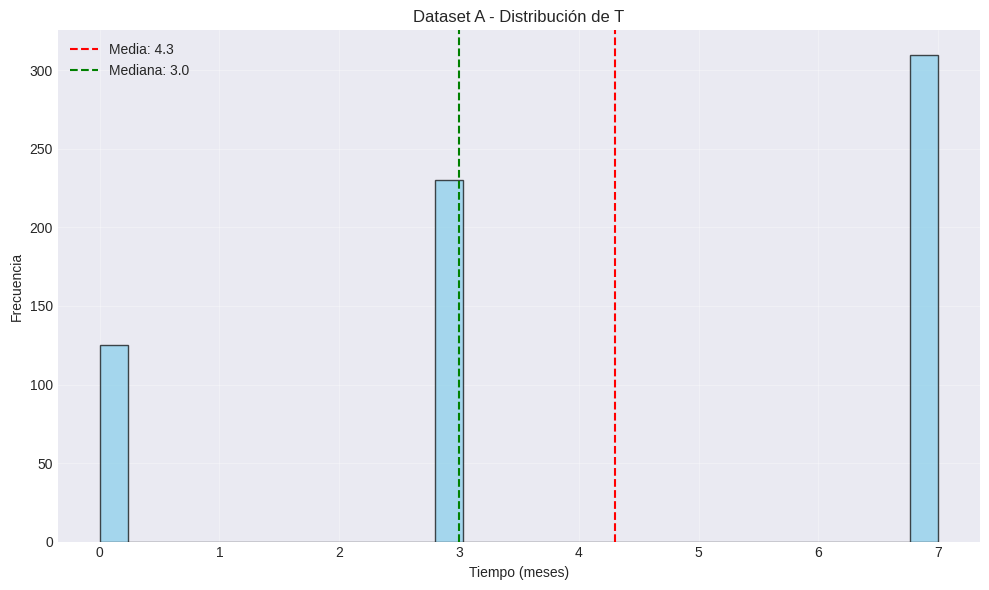

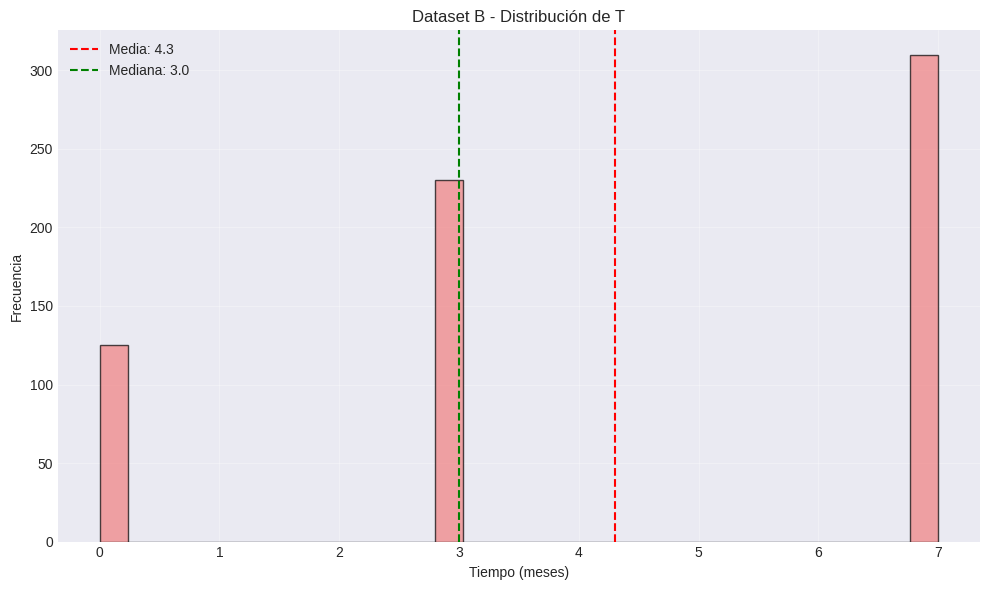

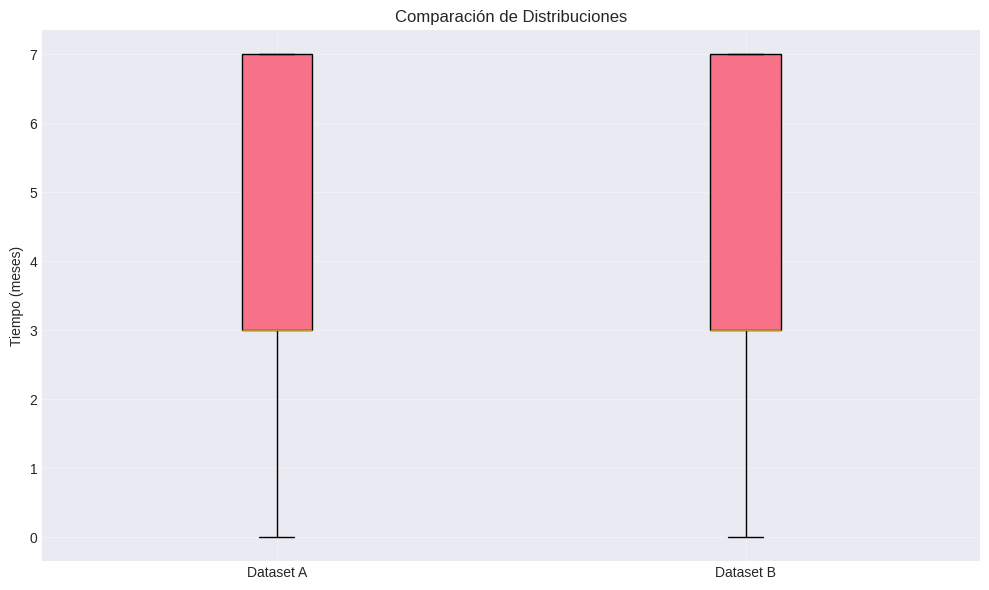

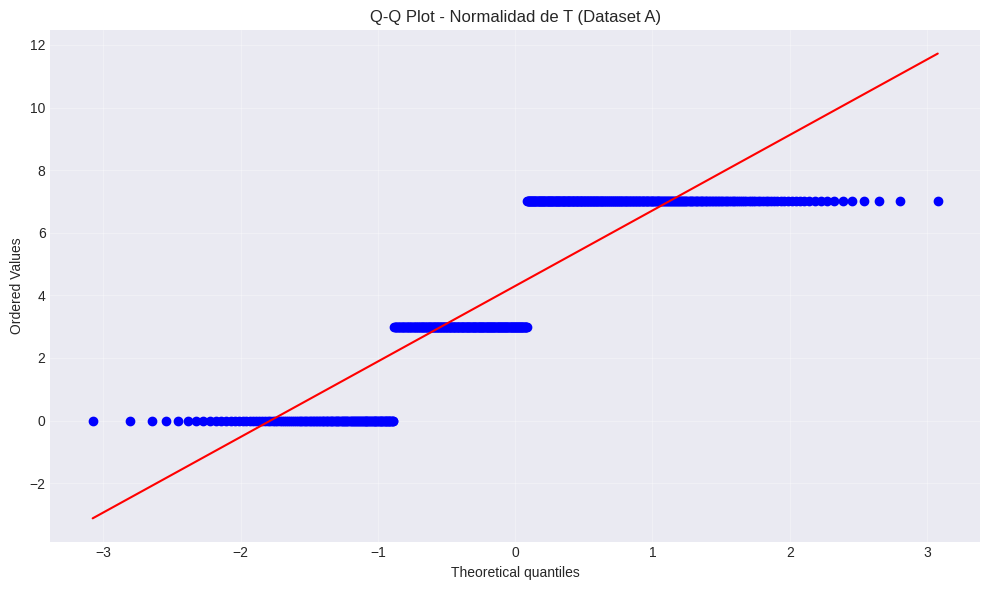


📊 Test de Normalidad (Shapiro-Wilk):
   • Dataset A: W=0.7714, p-value=2.0679e-29
   • Dataset B: W=0.7714, p-value=2.0679e-29
   • Interpretación: NO normal (α=0.05)


In [5]:
# ==============================================================================
# PASO 3: ANÁLISIS DE DISTRIBUCIÓN DEL TARGET
# ==============================================================================
print("\n[3/8] ANÁLISIS DE DISTRIBUCIÓN DEL TARGET")
print("-"*80)

# 1. Histograma Dataset A
plt.figure(figsize=(10, 6))
plt.hist(df_A[TARGET], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(df_A[TARGET].mean(), color='red', linestyle='--', 
            label=f'Media: {df_A[TARGET].mean():.1f}')
plt.axvline(df_A[TARGET].median(), color='green', linestyle='--', 
            label=f'Mediana: {df_A[TARGET].median():.1f}')
plt.title('Dataset A - Distribución de T')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Histograma Dataset B
plt.figure(figsize=(10, 6))
plt.hist(df_B[TARGET], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
plt.axvline(df_B[TARGET].mean(), color='red', linestyle='--', 
            label=f'Media: {df_B[TARGET].mean():.1f}')
plt.axvline(df_B[TARGET].median(), color='green', linestyle='--', 
            label=f'Mediana: {df_B[TARGET].median():.1f}')
plt.title('Dataset B - Distribución de T')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Boxplot comparativo
plt.figure(figsize=(10, 6))
data_box = [df_A[TARGET], df_B[TARGET]]
plt.boxplot(data_box, labels=['Dataset A', 'Dataset B'], patch_artist=True)
plt.title('Comparación de Distribuciones')
plt.ylabel('Tiempo (meses)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Q-Q Plot para normalidad (Dataset A)
plt.figure(figsize=(10, 6))
stats.probplot(df_A[TARGET], dist="norm", plot=plt)
plt.title('Q-Q Plot - Normalidad de T (Dataset A)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Test de normalidad
shapiro_A = stats.shapiro(df_A[TARGET].sample(min(5000, len(df_A))))
shapiro_B = stats.shapiro(df_B[TARGET].sample(min(5000, len(df_B))))
print(f"\n📊 Test de Normalidad (Shapiro-Wilk):")
print(f"   • Dataset A: W={shapiro_A.statistic:.4f}, p-value={shapiro_A.pvalue:.4e}")
print(f"   • Dataset B: W={shapiro_B.statistic:.4f}, p-value={shapiro_B.pvalue:.4e}")
print(f"   • Interpretación: {'NO normal' if shapiro_A.pvalue < 0.05 else 'Normal'} (α=0.05)")



[4/8] ANÁLISIS DE ESTRATIFICACIÓN POR CARRERA
--------------------------------------------------------------------------------

📚 Distribución de registros por Carrera:
                                 n  media  mediana   std  min  max
Carrera_Final                                                     
software                       129   3.61      3.0  2.91    0    7
ingenieria civil                72   4.76      7.0  2.46    0    7
mecanica                        67   4.51      3.0  2.58    0    7
computacion                     51   3.35      3.0  2.68    0    7
ingenieria ambiental            48   6.06      7.0  2.07    0    7
electronica y automatizacion    44   4.14      3.0  2.50    0    7
telecomunicaciones              39   4.26      3.0  2.92    0    7
ingenieria de la produccion     32   3.84      3.0  2.74    0    7
economia                        30   3.00      3.0  2.95    0    7
electricidad                    28   3.79      3.0  2.70    0    7
ingenieria quimica        

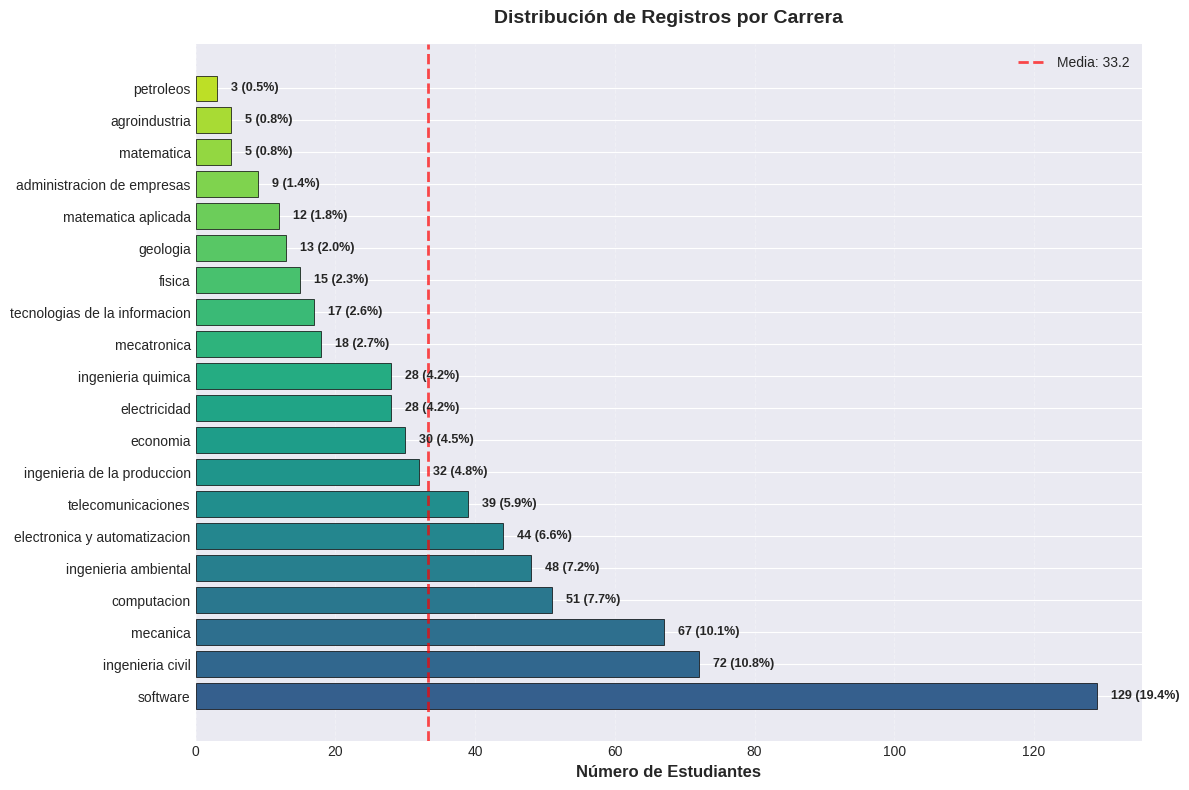

✓ Gráfico guardado: 02b_boxplot_T_por_carrera.png


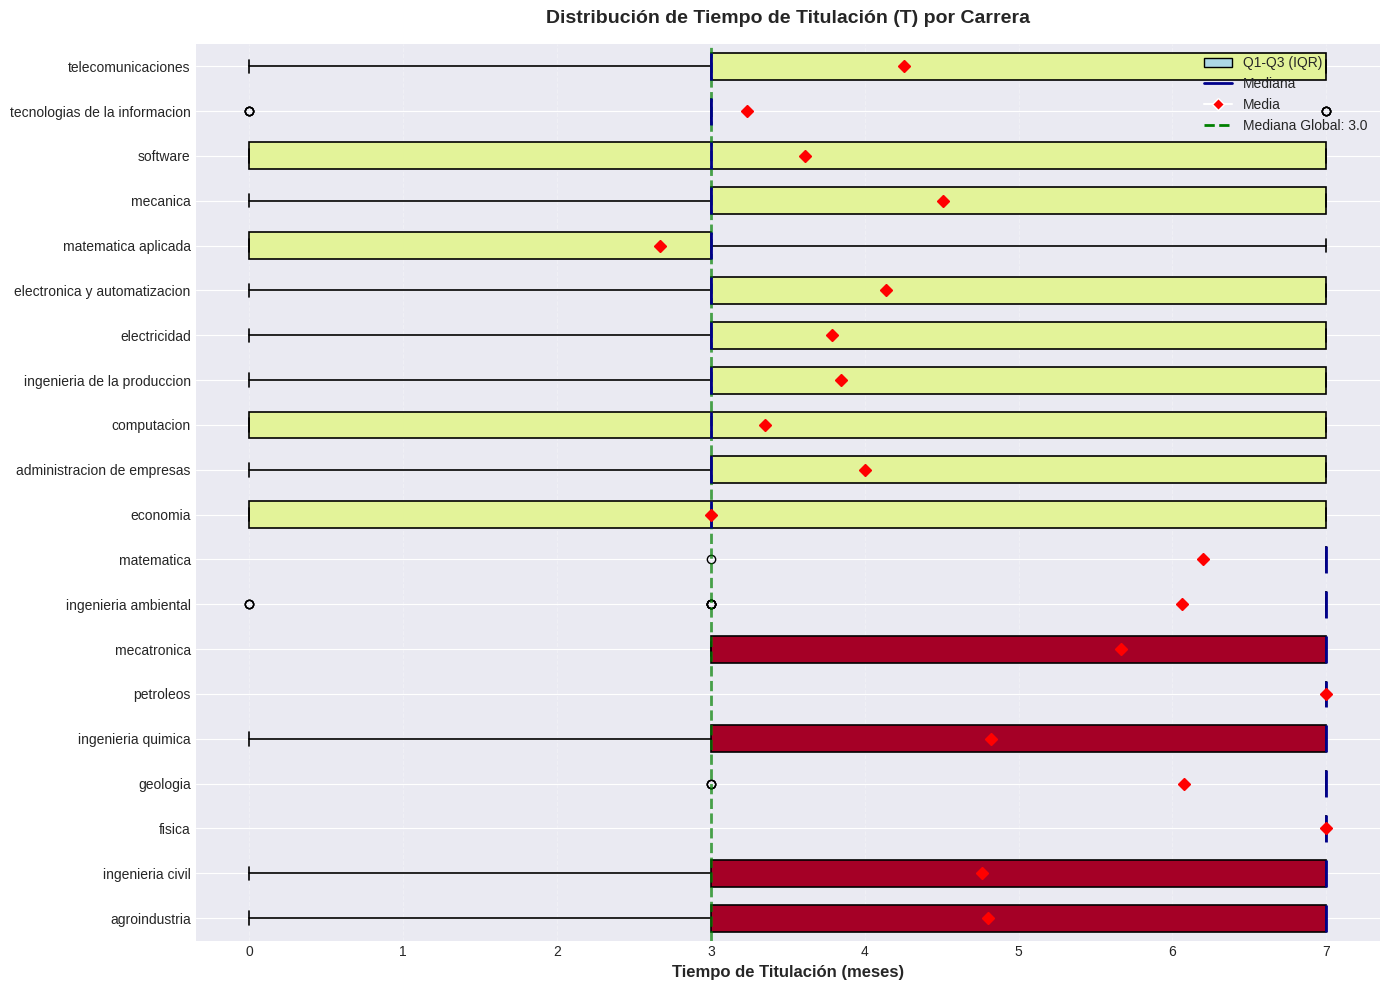

✓ Gráfico guardado: 02c_media_variabilidad_carrera.png


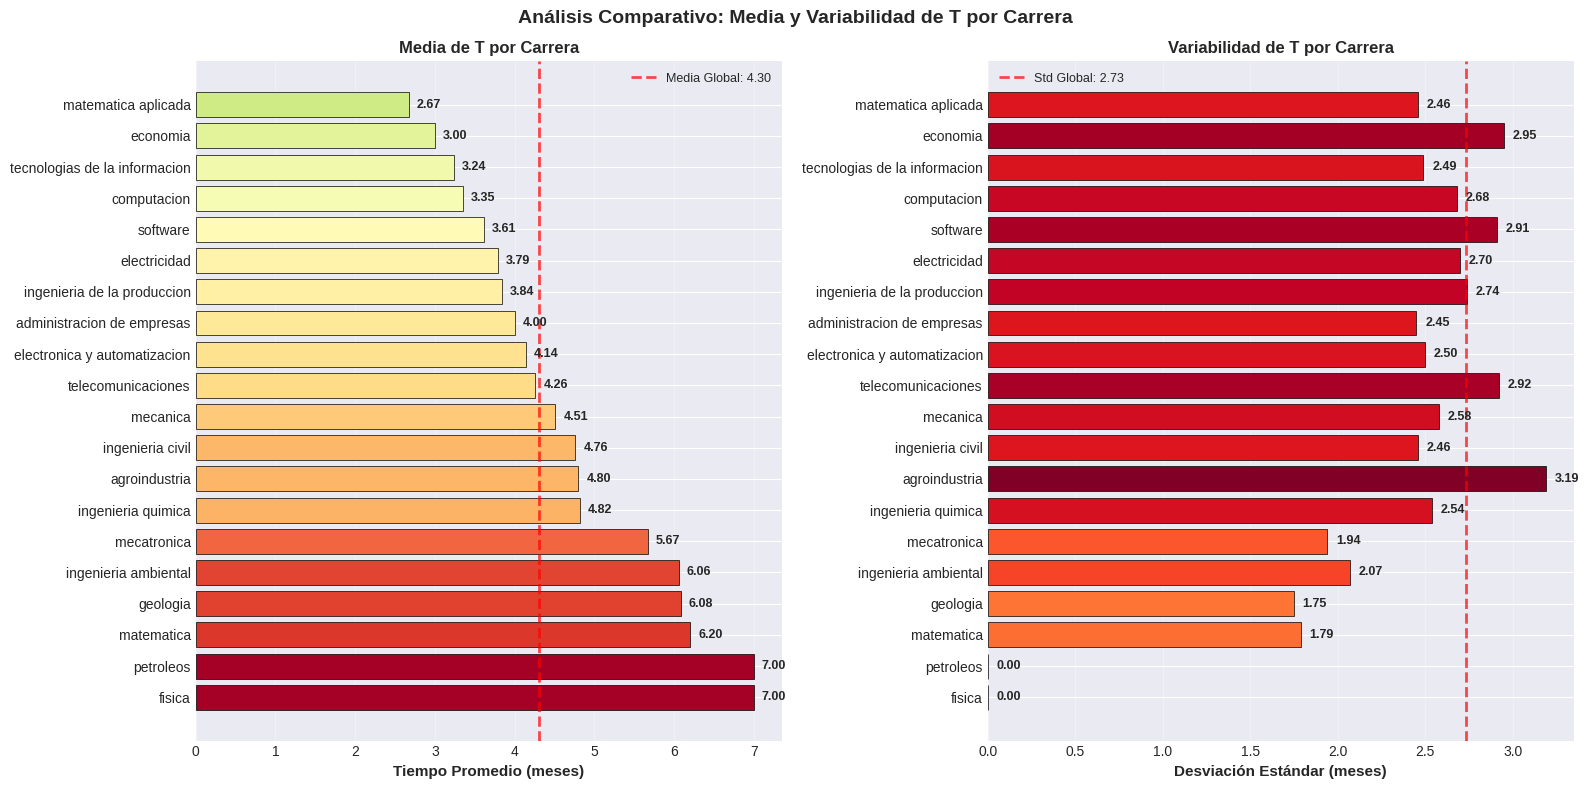


📊 Análisis de Balance para Estratificación:
--------------------------------------------------------------------------------

• Coeficiente de Variación entre grupos: 90.88%

⚠️  Grupos pequeños detectados (<5% del total):
   • ingenieria de la produccion: 32 estudiantes (4.81%)
   • economia: 30 estudiantes (4.51%)
   • electricidad: 28 estudiantes (4.21%)
   • ingenieria quimica: 28 estudiantes (4.21%)
   • mecatronica: 18 estudiantes (2.71%)
   • tecnologias de la informacion: 17 estudiantes (2.56%)
   • fisica: 15 estudiantes (2.26%)
   • geologia: 13 estudiantes (1.95%)
   • matematica aplicada: 12 estudiantes (1.80%)
   • administracion de empresas: 9 estudiantes (1.35%)
   • matematica: 5 estudiantes (0.75%)
   • agroindustria: 5 estudiantes (0.75%)
   • petroleos: 3 estudiantes (0.45%)

   RECOMENDACIÓN: Considerar agrupación o usar 'min_samples_split' en CV

• Muestras mínimas esperadas en test set (20%): 0.6
   ⚠️  ADVERTENCIA: Algunas carreras tendrán muy pocas muestras en 

In [7]:
# ==============================================================================
# PASO 4: ANÁLISIS DE ESTRATIFICACIÓN POR CARRERA
# ==============================================================================
print("\n[4/8] ANÁLISIS DE ESTRATIFICACIÓN POR CARRERA")
print("-"*80)

carrera_stats = df_A.groupby('Carrera_Final')[TARGET].agg([
    ('n', 'count'),
    ('media', 'mean'),
    ('mediana', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max')
]).round(2).sort_values('n', ascending=False)

print("\n📚 Distribución de registros por Carrera:")
print(carrera_stats)

# Calcular métricas adicionales
total_registros = len(df_A)
carrera_counts = df_A['Carrera_Final'].value_counts().sort_values(ascending=False)
n_carreras = len(carrera_counts)

print(f"\n📊 Resumen:")
print(f"   • Total de carreras: {n_carreras}")
print(f"   • Carrera más representada: {carrera_counts.index[0]} ({carrera_counts.iloc[0]} estudiantes, {carrera_counts.iloc[0]/total_registros*100:.1f}%)")
print(f"   • Carrera menos representada: {carrera_counts.index[-1]} ({carrera_counts.iloc[-1]} estudiantes, {carrera_counts.iloc[-1]/total_registros*100:.1f}%)")

# ==============================================================================
# GRÁFICO 1: BARPLOT HORIZONTAL - DISTRIBUCIÓN POR CARRERA
# ==============================================================================
fig = plt.figure(figsize=(12, max(8, n_carreras * 0.4)))
ax = plt.gca()

# Colores degradados
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(carrera_counts)))

# Crear barras horizontales
y_pos = np.arange(len(carrera_counts))
bars = ax.barh(y_pos, carrera_counts.values, color=colors, edgecolor='black', linewidth=0.5)

# Añadir valores al final de cada barra
for i, (count, bar) in enumerate(zip(carrera_counts.values, bars)):
    width = bar.get_width()
    percentage = (count / total_registros) * 100
    ax.text(width + 2, bar.get_y() + bar.get_height()/2, 
            f'{count} ({percentage:.1f}%)', 
            va='center', fontsize=9, fontweight='bold')

# Configuración de ejes
ax.set_yticks(y_pos)
ax.set_yticklabels(carrera_counts.index, fontsize=10)
ax.set_xlabel('Número de Estudiantes', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Registros por Carrera', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Línea de referencia (media)
mean_count = carrera_counts.mean()
ax.axvline(mean_count, color='red', linestyle='--', linewidth=2, 
           label=f'Media: {mean_count:.1f}', alpha=0.7)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('02a_distribucion_carreras.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico guardado: 02a_distribucion_carreras.png")
plt.show()

# ==============================================================================
# GRÁFICO 2: BOXPLOT - DISTRIBUCIÓN DE T POR CARRERA
# ==============================================================================
# Ordenar carreras por mediana de T para mejor visualización
carrera_orden = df_A.groupby('Carrera_Final')[TARGET].median().sort_values(ascending=False).index

fig = plt.figure(figsize=(14, max(8, n_carreras * 0.5)))
ax = plt.gca()

# Preparar datos para boxplot
data_boxplot = [df_A[df_A['Carrera_Final'] == carrera][TARGET].values 
                for carrera in carrera_orden]

# Crear boxplot con colores
bp = ax.boxplot(data_boxplot, vert=False, patch_artist=True, 
                widths=0.6, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='red', markersize=6),
                boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.2),
                whiskerprops=dict(linewidth=1.2),
                capprops=dict(linewidth=1.2),
                medianprops=dict(color='darkblue', linewidth=2))

# Colorear boxplots según mediana
medianas = [np.median(data) for data in data_boxplot]
colors_bp = plt.cm.RdYlGn_r(np.array(medianas) / max(medianas))
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)

# Configuración de ejes
ax.set_yticks(range(1, len(carrera_orden) + 1))
ax.set_yticklabels(carrera_orden, fontsize=10)
ax.set_xlabel('Tiempo de Titulación (meses)', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Tiempo de Titulación (T) por Carrera', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Línea de referencia (mediana global)
median_global = df_A[TARGET].median()
ax.axvline(median_global, color='green', linestyle='--', linewidth=2, 
           label=f'Mediana Global: {median_global:.1f} meses', alpha=0.7)

# Leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', edgecolor='black', label='Q1-Q3 (IQR)'),
    plt.Line2D([0], [0], color='darkblue', linewidth=2, label='Mediana'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='red', 
               markersize=6, label='Media'),
    plt.Line2D([0], [0], color='green', linestyle='--', linewidth=2, 
               label=f'Mediana Global: {median_global:.1f}')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('02b_boxplot_T_por_carrera.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 02b_boxplot_T_por_carrera.png")
plt.show()

# ==============================================================================
# GRÁFICO 3: HEATMAP - MEDIA Y VARIABILIDAD DE T POR CARRERA
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, max(8, n_carreras * 0.4)))
fig.suptitle('Análisis Comparativo: Media y Variabilidad de T por Carrera', 
             fontsize=14, fontweight='bold')

# Ordenar por media
carrera_stats_sorted = carrera_stats.sort_values('media', ascending=False)

# Subplot 1: Media
y_pos = np.arange(len(carrera_stats_sorted))
colors_media = plt.cm.RdYlGn_r(carrera_stats_sorted['media'].values / 
                                carrera_stats_sorted['media'].max())

bars1 = axes[0].barh(y_pos, carrera_stats_sorted['media'].values, 
                     color=colors_media, edgecolor='black', linewidth=0.5)

# Añadir valores
for i, (media, bar) in enumerate(zip(carrera_stats_sorted['media'].values, bars1)):
    axes[0].text(media + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{media:.2f}', va='center', fontsize=9, fontweight='bold')

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(carrera_stats_sorted.index, fontsize=10)
axes[0].set_xlabel('Tiempo Promedio (meses)', fontsize=11, fontweight='bold')
axes[0].set_title('Media de T por Carrera', fontsize=12, fontweight='bold')
axes[0].axvline(df_A[TARGET].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Media Global: {df_A[TARGET].mean():.2f}', alpha=0.7)
axes[0].legend(fontsize=9)
axes[0].grid(axis='x', alpha=0.3)

# Subplot 2: Desviación Estándar (Variabilidad)
colors_std = plt.cm.YlOrRd(carrera_stats_sorted['std'].values / 
                           carrera_stats_sorted['std'].max())

bars2 = axes[1].barh(y_pos, carrera_stats_sorted['std'].values, 
                     color=colors_std, edgecolor='black', linewidth=0.5)

# Añadir valores
for i, (std, bar) in enumerate(zip(carrera_stats_sorted['std'].values, bars2)):
    axes[1].text(std + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{std:.2f}', va='center', fontsize=9, fontweight='bold')

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(carrera_stats_sorted.index, fontsize=10)
axes[1].set_xlabel('Desviación Estándar (meses)', fontsize=11, fontweight='bold')
axes[1].set_title('Variabilidad de T por Carrera', fontsize=12, fontweight='bold')
axes[1].axvline(df_A[TARGET].std(), color='red', linestyle='--', 
                linewidth=2, label=f'Std Global: {df_A[TARGET].std():.2f}', alpha=0.7)
axes[1].legend(fontsize=9)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('02c_media_variabilidad_carrera.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 02c_media_variabilidad_carrera.png")
plt.show()

# ==============================================================================
# ANÁLISIS DE DESBALANCEO PARA ESTRATIFICACIÓN
# ==============================================================================
print("\n📊 Análisis de Balance para Estratificación:")
print("-"*80)

# Calcular coeficiente de variación de tamaños de grupos
cv_grupos = (carrera_counts.std() / carrera_counts.mean()) * 100
print(f"\n• Coeficiente de Variación entre grupos: {cv_grupos:.2f}%")

# Identificar grupos pequeños que podrían ser problemáticos
threshold_pequeno = 0.05 * total_registros  # 5% del total
grupos_pequenos = carrera_counts[carrera_counts < threshold_pequeno]

if len(grupos_pequenos) > 0:
    print(f"\n⚠️  Grupos pequeños detectados (<5% del total):")
    for carrera, count in grupos_pequenos.items():
        print(f"   • {carrera}: {count} estudiantes ({count/total_registros*100:.2f}%)")
    print(f"\n   RECOMENDACIÓN: Considerar agrupación o usar 'min_samples_split' en CV")
else:
    print(f"\n✓ No hay grupos excesivamente pequeños")

# Validar que habrá suficientes muestras en test set
min_samples_test = (carrera_counts * 0.20).min()
print(f"\n• Muestras mínimas esperadas en test set (20%): {min_samples_test:.1f}")

if min_samples_test < 5:
    print(f"   ⚠️  ADVERTENCIA: Algunas carreras tendrán muy pocas muestras en test")
    print(f"   SOLUCIÓN: Usar stratified split con random_state fijo")
else:
    print(f"   ✓ Tamaños de test set adecuados para todas las carreras")


[5/8] MATRIZ DE CORRELACIÓN - SOFT SKILLS
--------------------------------------------------------------------------------

🔗 Correlación de Soft Skills con T:

Dataset A:
S_Responsabilidad_Soc   -0.107085
S_Gestion_Proyectos     -0.112571
S_Comunicacion_ESP      -0.130914
S_Comunicacion_ING      -0.172180
S_Liderazgo_Equipo      -0.188393
S_Etica_Profesional     -0.232718
S_Aprendizaje_Dig       -0.379342
Name: T, dtype: float64

Dataset B:
S_Responsabilidad_Soc   -0.107085
S_Gestion_Proyectos     -0.112571
S_Comunicacion_ESP      -0.130914
S_Comunicacion_ING      -0.172180
S_Liderazgo_Equipo      -0.188393
S_Etica_Profesional     -0.232718
S_Aprendizaje_Dig       -0.379342
Name: T, dtype: float64

✓ Gráfico guardado: 03_correlacion_soft_skills.png


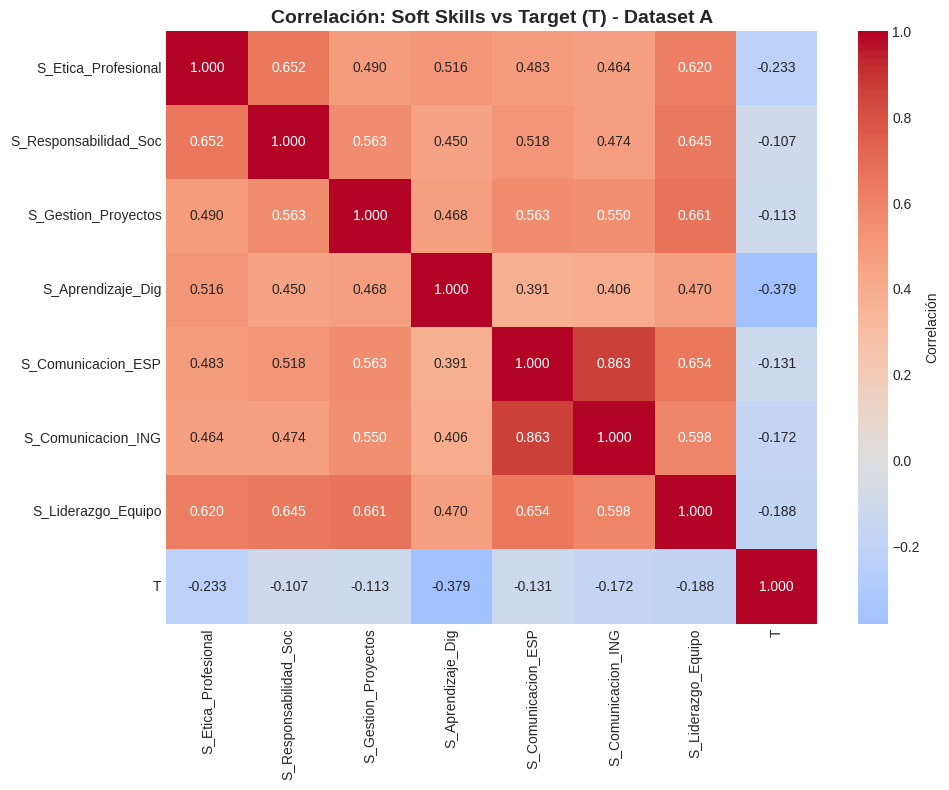

In [11]:
# ==============================================================================
# PASO 5: MATRIZ DE CORRELACIÓN - SOFT SKILLS vs TARGET
# ==============================================================================
print("\n[5/8] MATRIZ DE CORRELACIÓN - SOFT SKILLS")
print("-"*80)

# Calcular correlaciones con el target
corr_soft_A = df_A[SOFT_SKILLS + [TARGET]].corr()[TARGET].drop(TARGET).sort_values(ascending=False)
corr_soft_B = df_B[SOFT_SKILLS + [TARGET]].corr()[TARGET].drop(TARGET).sort_values(ascending=False)

# Se imprimen ambas para verificacion numérica, pero se graficará solo A ya que es representativa
print("\n🔗 Correlación de Soft Skills con T:")
print("\nDataset A:")
print(corr_soft_A)
print("\nDataset B:")
print(corr_soft_B)

# Visualización - Solo Dataset A
plt.figure(figsize=(10, 8))
plt.title('Correlación: Soft Skills vs Target (T) - Dataset A', fontsize=14, fontweight='bold')

# Heatmap Dataset A
sns.heatmap(df_A[SOFT_SKILLS + [TARGET]].corr(), annot=True, fmt='.3f', 
            cmap='coolwarm', center=0, cbar_kws={'label': 'Correlación'})

plt.tight_layout()
plt.savefig('03_correlacion_soft_skills.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico guardado: 03_correlacion_soft_skills.png")
plt.show()



[6/8] MATRIZ DE CORRELACIÓN - TECH SKILLS (TOP 20)
--------------------------------------------------------------------------------

🔗 TOP 20 Tech Skills correlacionadas con T:

Dataset A:
visualización de datos                                               0.166701
etl, latex, lte                                                      0.157644
react, revit                                                         0.156008
aws, wireless                                                        0.155888
finanzas, mercados financieros                                       0.153057
java, python                                                         0.148306
legislación ambiental, normas ambientales                            0.143202
crm, scrum                                                           0.133221
css, desarrollo web, html ...                                        0.129603
gis, git                                                             0.125264
tratamiento de aguas, tratamie

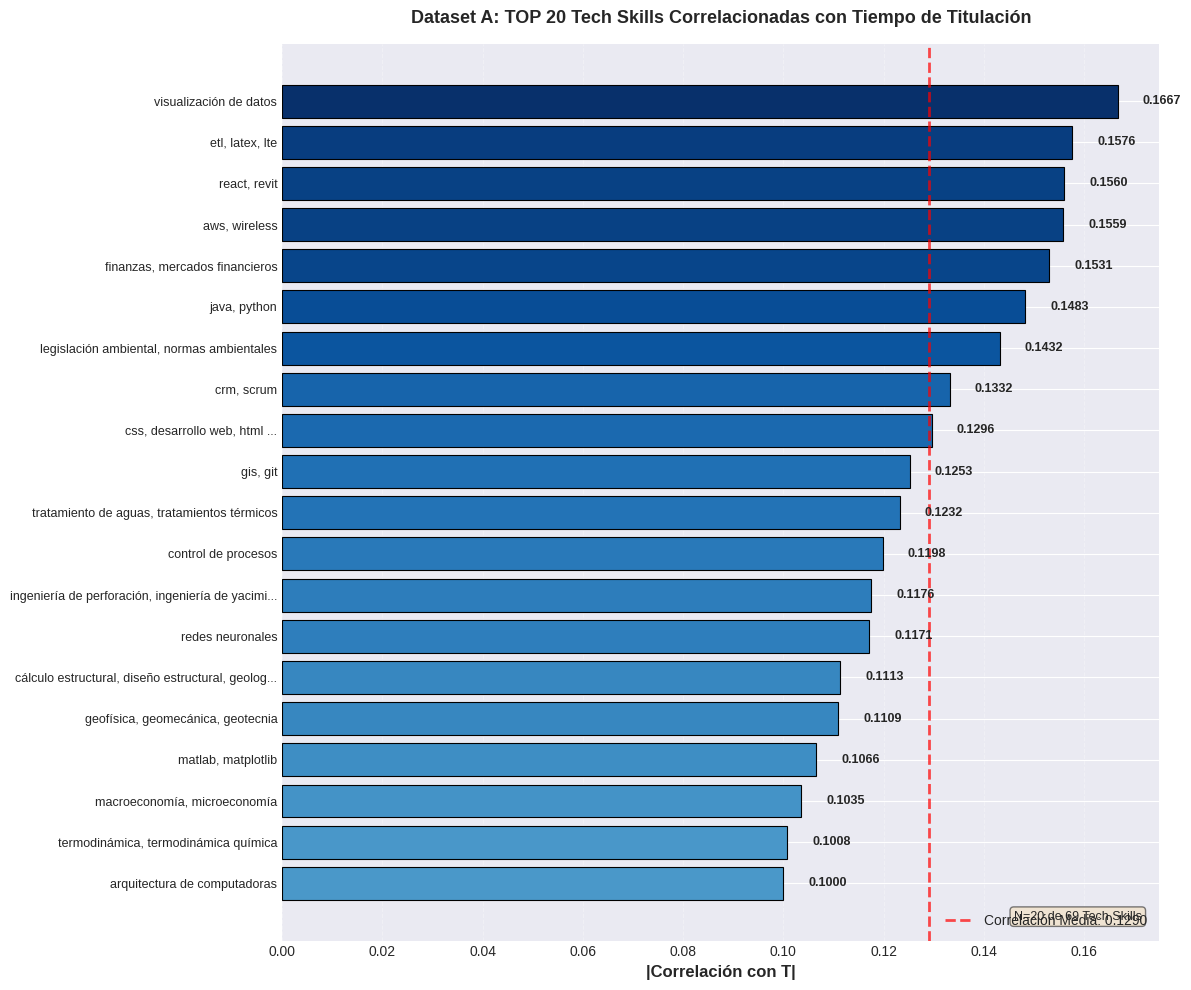

✓ Gráfico guardado: 04b_correlacion_tech_dataset_B.png


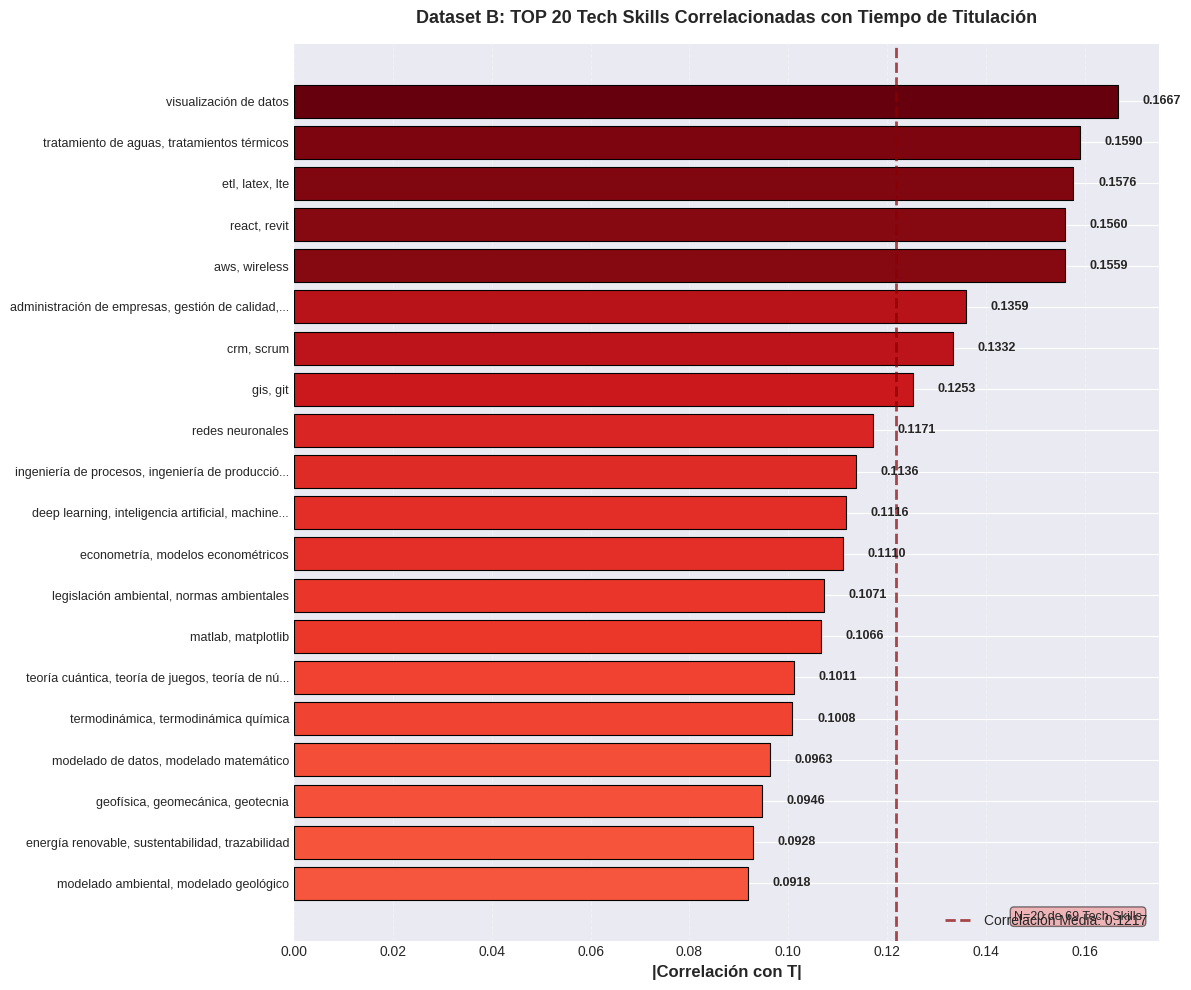


📊 Análisis Comparativo:
   • Skills en TOP 20 de ambos datasets: 12
   • Skills solo en TOP 20 de Dataset A: 8
   • Skills solo en TOP 20 de Dataset B: 8

🔗 Skills comunes en TOP 20:
   • redes neuronales
   • visualización de datos
   • tratamiento de aguas, tratamientos térmicos
   • crm, scrum
   • geofísica, geomecánica, geotecnia
   • matlab, matplotlib
   • etl, latex, lte
   • legislación ambiental, normas ambientales
   • react, revit
   • aws, wireless
   • termodinámica, termodinámica química
   • gis, git
✓ Gráfico guardado: 04c_comparacion_A_vs_B.png


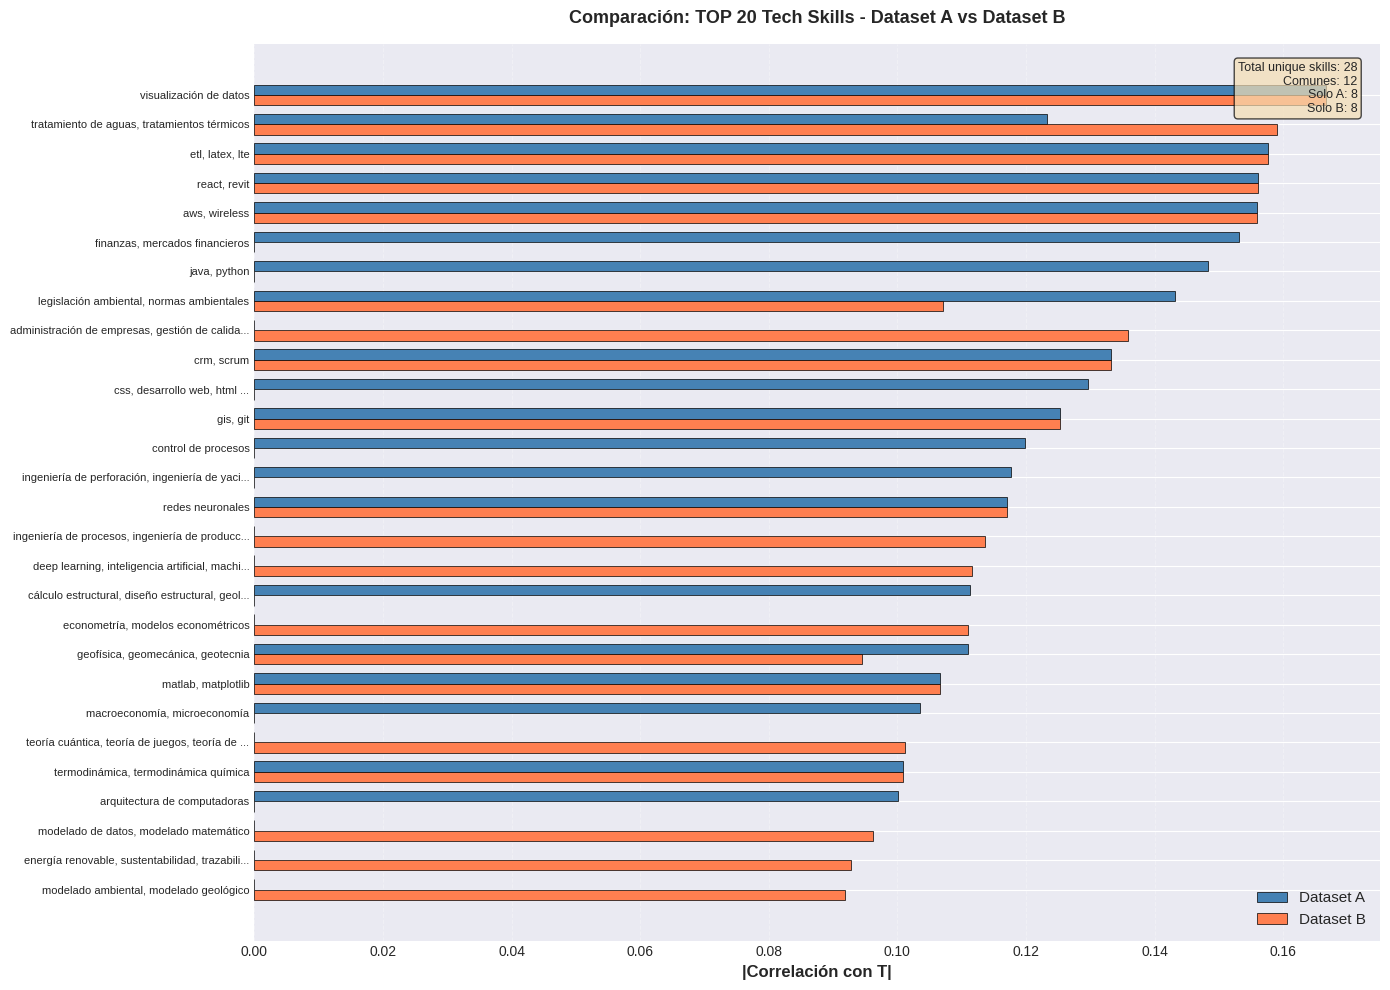

✓ Gráfico guardado: 04d_heatmap_correlaciones_top20.png


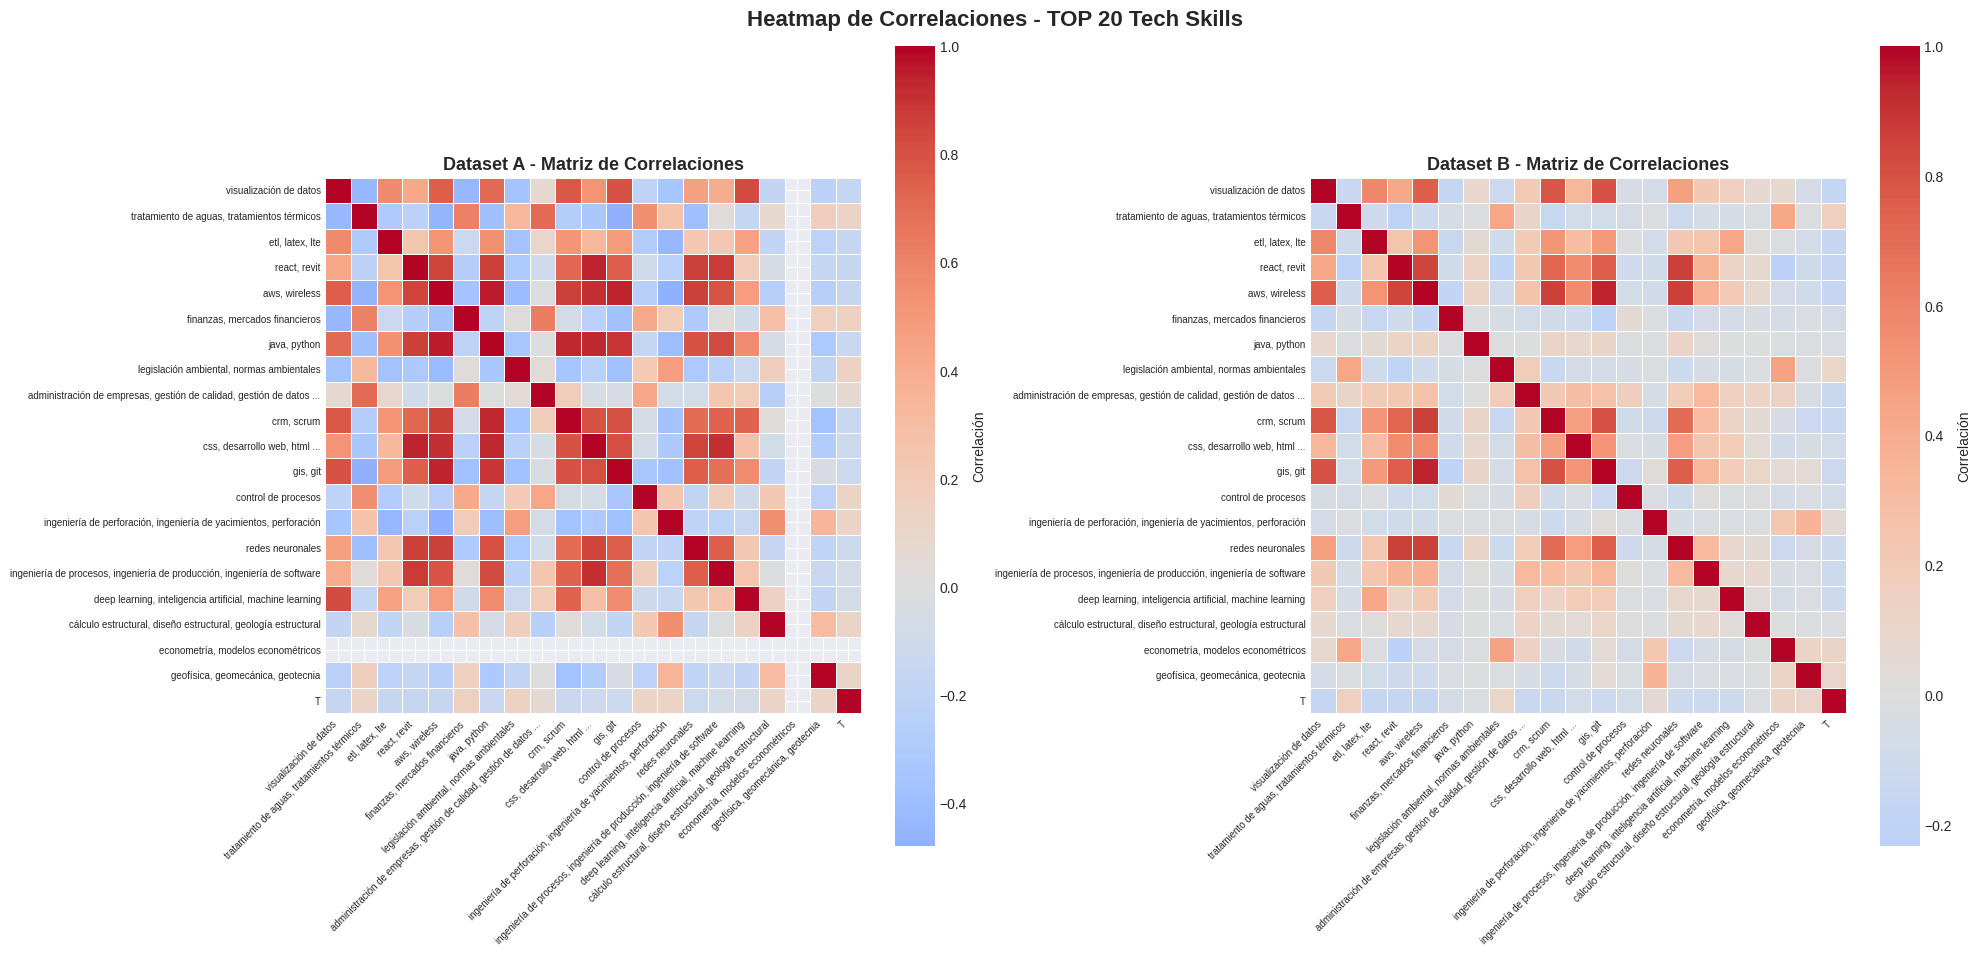


✓ PASO 6 COMPLETADO - 4 GRÁFICOS GENERADOS


In [13]:
# ==============================================================================
# PASO 6: MATRIZ DE CORRELACIÓN - TECH SKILLS (TOP 20)
# ==============================================================================
print("\n[6/8] MATRIZ DE CORRELACIÓN - TECH SKILLS (TOP 20)")
print("-"*80)

# Calcular correlaciones con el target
corr_tech_A = df_A[TECH_SKILLS + [TARGET]].corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)
corr_tech_B = df_B[TECH_SKILLS + [TARGET]].corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)

top_20_A = corr_tech_A.head(20)
top_20_B = corr_tech_B.head(20)

print("\n🔗 TOP 20 Tech Skills correlacionadas con T:")
print("\nDataset A:")
print(top_20_A)
print("\nDataset B:")
print(top_20_B)

# ==============================================================================
# GRÁFICO 1: DATASET A - TOP 20 CORRELACIONES
# ==============================================================================
fig = plt.figure(figsize=(12, 10))
ax = plt.gca()

# Colores degradados según magnitud de correlación
colors_A = plt.cm.Blues(top_20_A.values / top_20_A.max())

# Crear barras horizontales
y_pos = np.arange(len(top_20_A))
bars = ax.barh(y_pos, top_20_A.values, color=colors_A, edgecolor='black', linewidth=0.8)

# Añadir valores al final de cada barra
for i, (corr, bar) in enumerate(zip(top_20_A.values, bars)):
    ax.text(corr + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{corr:.4f}', va='center', fontsize=9, fontweight='bold')

# Configuración de ejes y etiquetas
ax.set_yticks(y_pos)
# Acortar nombres largos de forma más inteligente
labels_A = []
for skill in top_20_A.index:
    if len(skill) > 50:
        # Tomar primeras palabras hasta 50 caracteres
        labels_A.append(skill[:47] + '...')
    else:
        labels_A.append(skill)

ax.set_yticklabels(labels_A, fontsize=9)
ax.set_xlabel('|Correlación con T|', fontsize=12, fontweight='bold')
ax.set_title('Dataset A: TOP 20 Tech Skills Correlacionadas con Tiempo de Titulación', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.invert_yaxis()

# Añadir línea de referencia
mean_corr_A = top_20_A.mean()
ax.axvline(mean_corr_A, color='red', linestyle='--', linewidth=2, 
           label=f'Correlación Media: {mean_corr_A:.4f}', alpha=0.7)
ax.legend(loc='lower right', fontsize=10)

# Añadir anotación
ax.text(0.98, 0.02, f'N=20 de {len(TECH_SKILLS)} Tech Skills', 
        transform=ax.transAxes, fontsize=9, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('04a_correlacion_tech_dataset_A.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico guardado: 04a_correlacion_tech_dataset_A.png")
plt.show()

# ==============================================================================
# GRÁFICO 2: DATASET B - TOP 20 CORRELACIONES
# ==============================================================================
fig = plt.figure(figsize=(12, 10))
ax = plt.gca()

# Colores degradados según magnitud de correlación
colors_B = plt.cm.Reds(top_20_B.values / top_20_B.max())

# Crear barras horizontales
y_pos = np.arange(len(top_20_B))
bars = ax.barh(y_pos, top_20_B.values, color=colors_B, edgecolor='black', linewidth=0.8)

# Añadir valores al final de cada barra
for i, (corr, bar) in enumerate(zip(top_20_B.values, bars)):
    ax.text(corr + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{corr:.4f}', va='center', fontsize=9, fontweight='bold')

# Configuración de ejes y etiquetas
ax.set_yticks(y_pos)
# Acortar nombres largos de forma más inteligente
labels_B = []
for skill in top_20_B.index:
    if len(skill) > 50:
        labels_B.append(skill[:47] + '...')
    else:
        labels_B.append(skill)

ax.set_yticklabels(labels_B, fontsize=9)
ax.set_xlabel('|Correlación con T|', fontsize=12, fontweight='bold')
ax.set_title('Dataset B: TOP 20 Tech Skills Correlacionadas con Tiempo de Titulación', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.invert_yaxis()

# Añadir línea de referencia
mean_corr_B = top_20_B.mean()
ax.axvline(mean_corr_B, color='darkred', linestyle='--', linewidth=2, 
           label=f'Correlación Media: {mean_corr_B:.4f}', alpha=0.7)
ax.legend(loc='lower right', fontsize=10)

# Añadir anotación
ax.text(0.98, 0.02, f'N=20 de {len(TECH_SKILLS)} Tech Skills', 
        transform=ax.transAxes, fontsize=9, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.savefig('04b_correlacion_tech_dataset_B.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 04b_correlacion_tech_dataset_B.png")
plt.show()

# ==============================================================================
# GRÁFICO 3: COMPARACIÓN DIRECTA A vs B
# ==============================================================================
fig = plt.figure(figsize=(14, 10))
ax = plt.gca()

# Encontrar skills comunes en ambos TOP 20
skills_comunes = list(set(top_20_A.index) & set(top_20_B.index))
skills_solo_A = list(set(top_20_A.index) - set(top_20_B.index))
skills_solo_B = list(set(top_20_B.index) - set(top_20_A.index))

print(f"\n📊 Análisis Comparativo:")
print(f"   • Skills en TOP 20 de ambos datasets: {len(skills_comunes)}")
print(f"   • Skills solo en TOP 20 de Dataset A: {len(skills_solo_A)}")
print(f"   • Skills solo en TOP 20 de Dataset B: {len(skills_solo_B)}")

if len(skills_comunes) > 0:
    print(f"\n🔗 Skills comunes en TOP 20:")
    for skill in skills_comunes:
        print(f"   • {skill[:60]}")

# Crear todas las skills únicas del TOP 20
all_top_skills = list(set(list(top_20_A.index) + list(top_20_B.index)))
all_top_skills = sorted(all_top_skills, 
                        key=lambda x: max(top_20_A.get(x, 0), top_20_B.get(x, 0)), 
                        reverse=True)

# Preparar datos para comparación
corr_A_values = [top_20_A.get(skill, 0) for skill in all_top_skills]
corr_B_values = [top_20_B.get(skill, 0) for skill in all_top_skills]

# Crear gráfico de barras agrupadas
x = np.arange(len(all_top_skills))
width = 0.35

bars1 = ax.barh(x - width/2, corr_A_values, width, label='Dataset A', 
                color='steelblue', edgecolor='black', linewidth=0.5)
bars2 = ax.barh(x + width/2, corr_B_values, width, label='Dataset B', 
                color='coral', edgecolor='black', linewidth=0.5)

# Configuración
ax.set_yticks(x)
labels_comp = [skill[:45] + '...' if len(skill) > 45 else skill for skill in all_top_skills]
ax.set_yticklabels(labels_comp, fontsize=8)
ax.set_xlabel('|Correlación con T|', fontsize=12, fontweight='bold')
ax.set_title('Comparación: TOP 20 Tech Skills - Dataset A vs Dataset B', 
             fontsize=13, fontweight='bold', pad=15)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.invert_yaxis()

# Añadir anotación
textstr = f'Total unique skills: {len(all_top_skills)}\nComunes: {len(skills_comunes)}\nSolo A: {len(skills_solo_A)}\nSolo B: {len(skills_solo_B)}'
ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('04c_comparacion_A_vs_B.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 04c_comparacion_A_vs_B.png")
plt.show()

# ==============================================================================
# GRÁFICO 4: HEATMAP DE CORRELACIONES - TOP 20 SKILLS MÁS IMPORTANTES
# ==============================================================================
# Seleccionar las TOP 20 skills más correlacionadas considerando ambos datasets
top_combined = pd.concat([top_20_A, top_20_B]).groupby(level=0).max().sort_values(ascending=False).head(20)

# Crear matriz de correlación para estas skills
skills_for_heatmap = list(top_combined.index)
corr_matrix_A = df_A[skills_for_heatmap + [TARGET]].corr()
corr_matrix_B = df_B[skills_for_heatmap + [TARGET]].corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Heatmap de Correlaciones - TOP 20 Tech Skills', fontsize=16, fontweight='bold')

# Heatmap Dataset A
sns.heatmap(corr_matrix_A, annot=False, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0], cbar_kws={'label': 'Correlación'},
            linewidths=0.5, square=True)
axes[0].set_title('Dataset A - Matriz de Correlaciones', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=7)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=7)

# Heatmap Dataset B
sns.heatmap(corr_matrix_B, annot=False, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[1], cbar_kws={'label': 'Correlación'},
            linewidths=0.5, square=True)
axes[1].set_title('Dataset B - Matriz de Correlaciones', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=7)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=7)

plt.tight_layout()
plt.savefig('04d_heatmap_correlaciones_top20.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 04d_heatmap_correlaciones_top20.png")
plt.show()

print("\n" + "="*80)
print("✓ PASO 6 COMPLETADO - 4 GRÁFICOS GENERADOS")
print("="*80)


[7/8] ANÁLISIS DE MULTICOLINEALIDAD (VIF)
--------------------------------------------------------------------------------

🔍 Calculando VIF para Soft Skills...

Dataset A - VIF Soft Skills:
                 Feature        VIF
4     S_Comunicacion_ESP  56.891215
5     S_Comunicacion_ING  47.593979
6     S_Liderazgo_Equipo  41.466288
0    S_Etica_Profesional  36.845597
1  S_Responsabilidad_Soc  32.467259
2    S_Gestion_Proyectos  28.046012
3      S_Aprendizaje_Dig  26.383151

⚠️  Variables con VIF > 10 (multicolinealidad alta): 7
⚠️  Variables con VIF > 5: 7

Dataset B - VIF Soft Skills:
                 Feature        VIF
4     S_Comunicacion_ESP  56.891215
5     S_Comunicacion_ING  47.593979
6     S_Liderazgo_Equipo  41.466288
0    S_Etica_Profesional  36.845597
1  S_Responsabilidad_Soc  32.467259
2    S_Gestion_Proyectos  28.046012
3      S_Aprendizaje_Dig  26.383151

⚠️  Variables con VIF > 10 (multicolinealidad alta): 7
⚠️  Variables con VIF > 5: 7

📖 Interpretación VIF:
   • VIF 

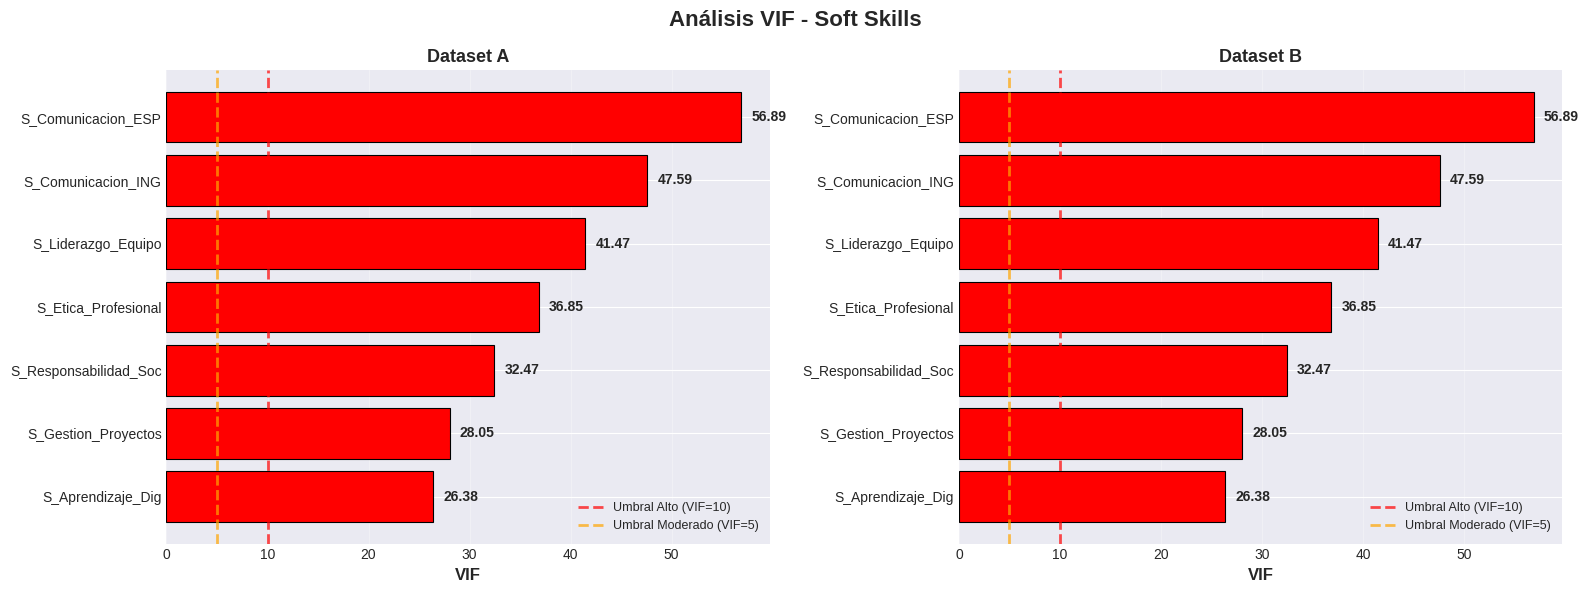


📊 Analizando matriz de correlación entre Soft Skills...

🔗 Pares de Soft Skills con |r| > 0.7:

Dataset A:
              Var1               Var2  Correlation
S_Comunicacion_ESP S_Comunicacion_ING     0.862691

Dataset B:
              Var1               Var2  Correlation
S_Comunicacion_ESP S_Comunicacion_ING     0.862691
✓ Gráfico guardado: 05b_correlacion_soft_skills_heatmap.png


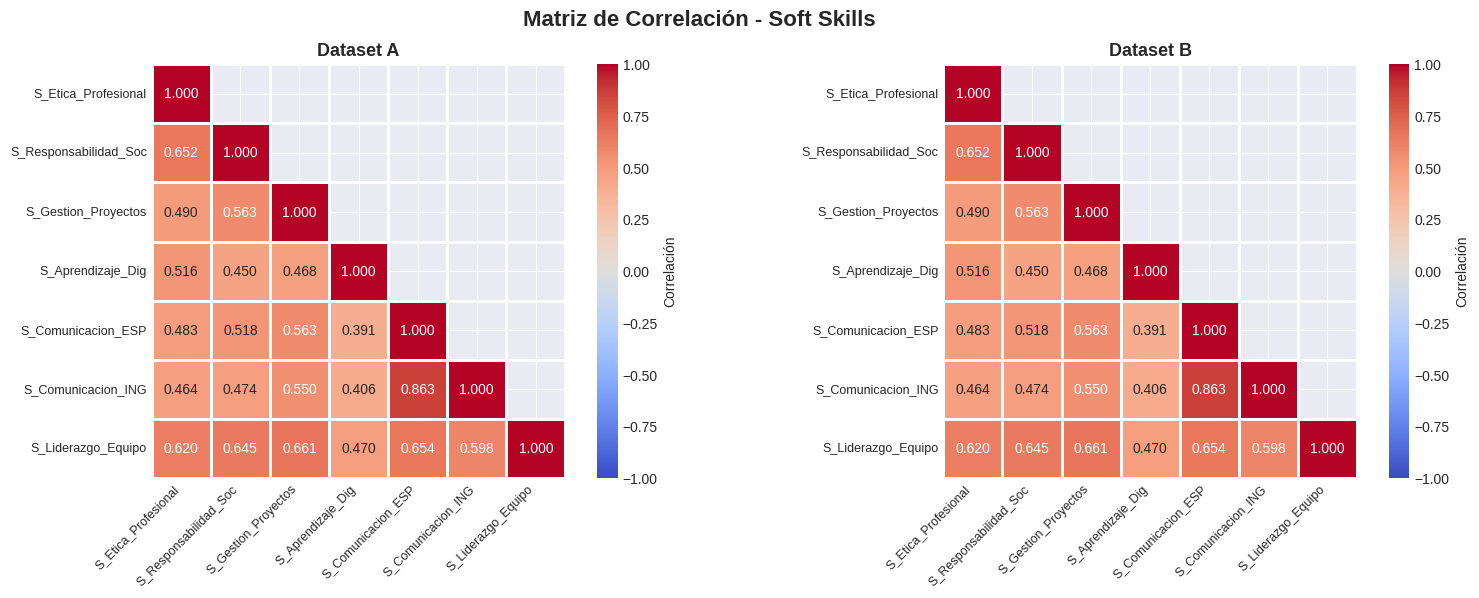


🔍 Calculando VIF para TOP 20 Tech Skills...
   Calculando VIF para 20 Tech Skills más correlacionadas...

Dataset A - VIF TOP 20 Tech Skills:
                              Feature          VIF
7                          crm, scrum  2400.818848
3                       aws, wireless  1866.218980
1                     etl, latex, lte  1745.180858
5                        java, python  1678.160066
9                            gis, git  1414.554554
8       css, desarrollo web, html ...  1037.058802
19       arquitectura de computadoras   644.417672
4      finanzas, mercados financieros   511.606547
0              visualización de datos   401.918856
15  geofísica, geomecánica, geotecnia   171.943301

⚠️  Variables con VIF > 10: 19
⚠️  Variables con VIF > 5: 20

Dataset B - VIF TOP 20 Tech Skills:
                                 Feature        VIF
3                          aws, wireless  99.904488
9                               gis, git  35.045675
2                           react, revit 

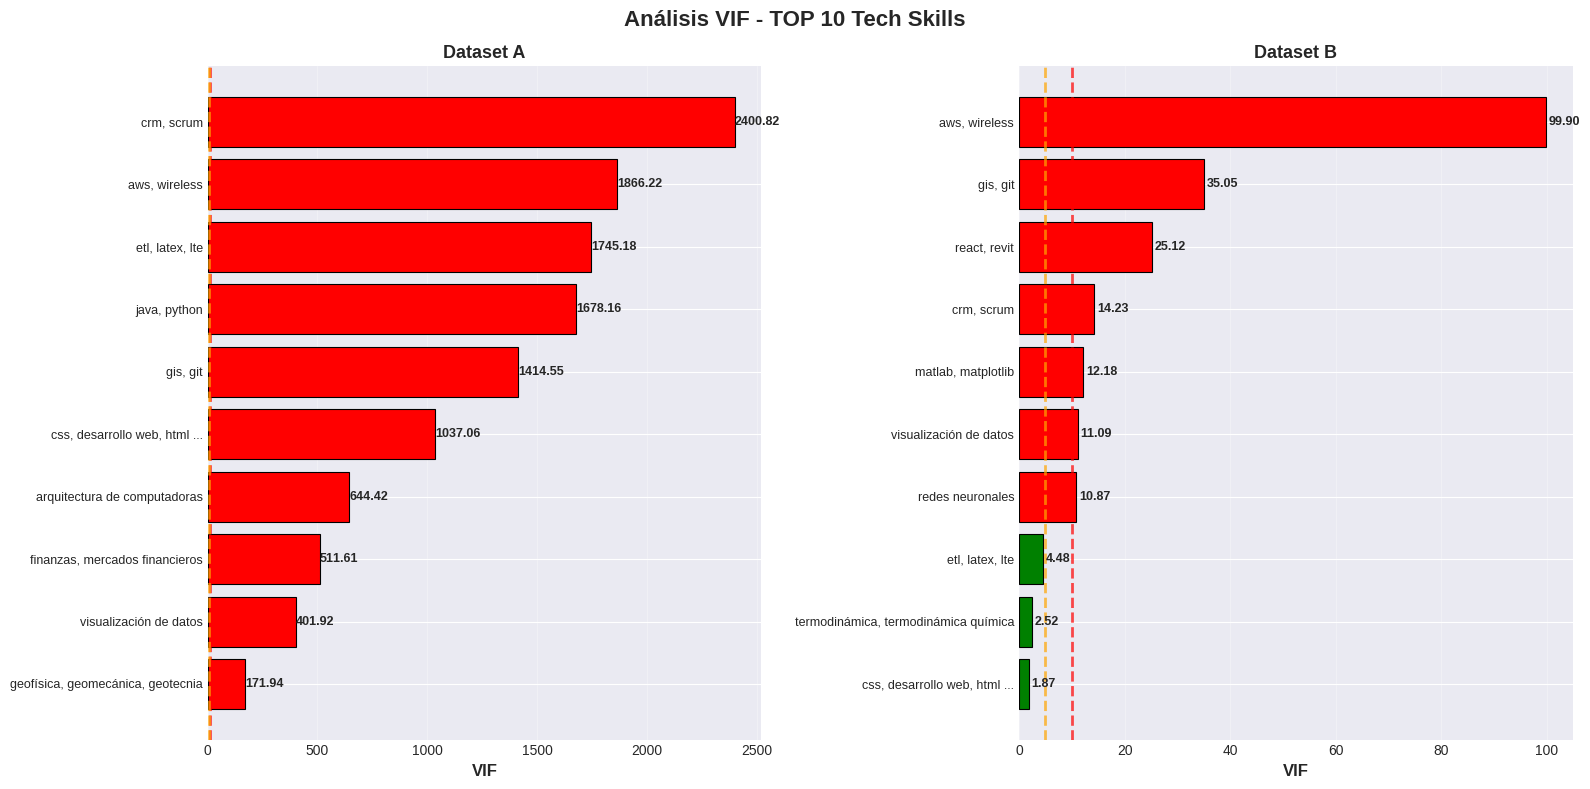


RESUMEN: ANÁLISIS DE MULTICOLINEALIDAD

📊 HALLAZGOS PRINCIPALES:

1. SOFT SKILLS (7 variables):
   • TODAS tienen VIF > 10 (multicolinealidad alta)
   • Máximo VIF: 56.89
   • Esto indica que las Soft Skills están fuertemente correlacionadas entre sí
   • Razón: Variables de autoevaluación tienden a tener respuestas correlacionadas

2. TECH SKILLS (TOP 20):
   • Variables con VIF > 10: 19
   • Variables con VIF > 5: 20
   • Menos problemático que Soft Skills

🎯 INTERPRETACIÓN PARA TU TESIS:

✓ PARA MODELOS DE ÁRBOLES (XGBoost y Random Forest):
  • La multicolinealidad NO es un problema crítico
  • Estos modelos son ROBUSTOS ante variables correlacionadas
  • NO es necesario eliminar variables por VIF alto
  • Los árboles pueden capturar patrones complejos sin verse afectados

⚠️ SI USARAS MODELOS LINEALES (NO es tu caso):
  • Regresión lineal, LASSO, Ridge SÍ se verían afectados
  • Sería necesario eliminar variables o usar PCA
  • Los coeficientes serían inestables

📋 RECOMENDACIONES

In [15]:
# ==============================================================================
# PASO 7: ANÁLISIS DE MULTICOLINEALIDAD (VIF)
# ==============================================================================
print("\n[7/8] ANÁLISIS DE MULTICOLINEALIDAD (VIF)")
print("-"*80)

def calculate_vif(df, features, sample_size=500):
    """Calcula VIF para detectar multicolinealidad"""
    # Muestrear para acelerar cálculo
    df_sample = df[features].dropna().sample(min(sample_size, len(df)), random_state=42)
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df_sample.values, i) 
                       for i in range(len(features))]
    
    return vif_data.sort_values('VIF', ascending=False)

# ==============================================================================
# VIF: SOFT SKILLS
# ==============================================================================
print("\n🔍 Calculando VIF para Soft Skills...")
vif_soft_A = calculate_vif(df_A, SOFT_SKILLS)
vif_soft_B = calculate_vif(df_B, SOFT_SKILLS)

print("\nDataset A - VIF Soft Skills:")
print(vif_soft_A)
print(f"\n⚠️  Variables con VIF > 10 (multicolinealidad alta): {len(vif_soft_A[vif_soft_A['VIF'] > 10])}")
print(f"⚠️  Variables con VIF > 5: {len(vif_soft_A[vif_soft_A['VIF'] > 5])}")

print("\nDataset B - VIF Soft Skills:")
print(vif_soft_B)
print(f"\n⚠️  Variables con VIF > 10 (multicolinealidad alta): {len(vif_soft_B[vif_soft_B['VIF'] > 10])}")
print(f"⚠️  Variables con VIF > 5: {len(vif_soft_B[vif_soft_B['VIF'] > 5])}")

# Interpretación VIF
print("\n📖 Interpretación VIF:")
print("   • VIF < 5: No hay multicolinealidad preocupante")
print("   • VIF 5-10: Multicolinealidad moderada")
print("   • VIF > 10: Multicolinealidad alta (considerar eliminación)")

# ==============================================================================
# GRÁFICO 1: VIF SOFT SKILLS - COMPARACIÓN A vs B
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Análisis VIF - Soft Skills', fontsize=16, fontweight='bold')

# Dataset A
colors_A = ['red' if vif > 10 else 'orange' if vif > 5 else 'green' 
            for vif in vif_soft_A['VIF']]
bars_A = axes[0].barh(range(len(vif_soft_A)), vif_soft_A['VIF'], 
                      color=colors_A, edgecolor='black', linewidth=0.8)

# Añadir valores
for i, (vif, bar) in enumerate(zip(vif_soft_A['VIF'], bars_A)):
    axes[0].text(vif + 1, bar.get_y() + bar.get_height()/2, 
                f'{vif:.2f}', va='center', fontsize=10, fontweight='bold')

axes[0].set_yticks(range(len(vif_soft_A)))
axes[0].set_yticklabels(vif_soft_A['Feature'], fontsize=10)
axes[0].set_xlabel('VIF', fontsize=12, fontweight='bold')
axes[0].set_title('Dataset A', fontsize=13, fontweight='bold')
axes[0].axvline(10, color='red', linestyle='--', linewidth=2, 
                label='Umbral Alto (VIF=10)', alpha=0.7)
axes[0].axvline(5, color='orange', linestyle='--', linewidth=2, 
                label='Umbral Moderado (VIF=5)', alpha=0.7)
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Dataset B
colors_B = ['red' if vif > 10 else 'orange' if vif > 5 else 'green' 
            for vif in vif_soft_B['VIF']]
bars_B = axes[1].barh(range(len(vif_soft_B)), vif_soft_B['VIF'], 
                      color=colors_B, edgecolor='black', linewidth=0.8)

# Añadir valores
for i, (vif, bar) in enumerate(zip(vif_soft_B['VIF'], bars_B)):
    axes[1].text(vif + 1, bar.get_y() + bar.get_height()/2, 
                f'{vif:.2f}', va='center', fontsize=10, fontweight='bold')

axes[1].set_yticks(range(len(vif_soft_B)))
axes[1].set_yticklabels(vif_soft_B['Feature'], fontsize=10)
axes[1].set_xlabel('VIF', fontsize=12, fontweight='bold')
axes[1].set_title('Dataset B', fontsize=13, fontweight='bold')
axes[1].axvline(10, color='red', linestyle='--', linewidth=2, 
                label='Umbral Alto (VIF=10)', alpha=0.7)
axes[1].axvline(5, color='orange', linestyle='--', linewidth=2, 
                label='Umbral Moderado (VIF=5)', alpha=0.7)
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('05a_vif_soft_skills.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico guardado: 05a_vif_soft_skills.png")
plt.show()

# ==============================================================================
# ANÁLISIS DE CORRELACIÓN ENTRE SOFT SKILLS
# ==============================================================================
print("\n📊 Analizando matriz de correlación entre Soft Skills...")

# Calcular correlaciones
corr_soft_A = df_A[SOFT_SKILLS].corr()
corr_soft_B = df_B[SOFT_SKILLS].corr()

# Encontrar pares altamente correlacionados (|r| > 0.7)
def find_high_correlations(corr_matrix, threshold=0.7):
    """Encuentra pares de variables con correlación > threshold"""
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'Var1': corr_matrix.columns[i],
                    'Var2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
    return pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                     key=abs, ascending=False)

high_corr_A = find_high_correlations(corr_soft_A, threshold=0.7)
high_corr_B = find_high_correlations(corr_soft_B, threshold=0.7)

print("\n🔗 Pares de Soft Skills con |r| > 0.7:")
print("\nDataset A:")
if len(high_corr_A) > 0:
    print(high_corr_A.to_string(index=False))
else:
    print("   No hay pares con correlación > 0.7")

print("\nDataset B:")
if len(high_corr_B) > 0:
    print(high_corr_B.to_string(index=False))
else:
    print("   No hay pares con correlación > 0.7")

# ==============================================================================
# GRÁFICO 2: HEATMAP CORRELACIONES SOFT SKILLS
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Matriz de Correlación - Soft Skills', fontsize=16, fontweight='bold')

# Dataset A
mask_A = np.triu(np.ones_like(corr_soft_A, dtype=bool), k=1)
sns.heatmap(corr_soft_A, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, ax=axes[0], cbar_kws={'label': 'Correlación'},
            linewidths=1, square=True, mask=mask_A,
            vmin=-1, vmax=1)
axes[0].set_title('Dataset A', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0, fontsize=9)

# Dataset B
mask_B = np.triu(np.ones_like(corr_soft_B, dtype=bool), k=1)
sns.heatmap(corr_soft_B, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, ax=axes[1], cbar_kws={'label': 'Correlación'},
            linewidths=1, square=True, mask=mask_B,
            vmin=-1, vmax=1)
axes[1].set_title('Dataset B', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=9)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('05b_correlacion_soft_skills_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 05b_correlacion_soft_skills_heatmap.png")
plt.show()

# ==============================================================================
# VIF: TOP 20 TECH SKILLS
# ==============================================================================
print("\n🔍 Calculando VIF para TOP 20 Tech Skills...")

# Obtener TOP 20 por correlación con target
corr_tech_A = df_A[TECH_SKILLS + [TARGET]].corr()[TARGET].drop(TARGET).abs().sort_values(ascending=False)
top_20_tech = list(corr_tech_A.head(20).index)

print(f"   Calculando VIF para {len(top_20_tech)} Tech Skills más correlacionadas...")

try:
    vif_tech_A = calculate_vif(df_A, top_20_tech, sample_size=500)
    vif_tech_B = calculate_vif(df_B, top_20_tech, sample_size=500)
    
    print("\nDataset A - VIF TOP 20 Tech Skills:")
    print(vif_tech_A.head(10))
    print(f"\n⚠️  Variables con VIF > 10: {len(vif_tech_A[vif_tech_A['VIF'] > 10])}")
    print(f"⚠️  Variables con VIF > 5: {len(vif_tech_A[vif_tech_A['VIF'] > 5])}")
    
    print("\nDataset B - VIF TOP 20 Tech Skills:")
    print(vif_tech_B.head(10))
    print(f"\n⚠️  Variables con VIF > 10: {len(vif_tech_B[vif_tech_B['VIF'] > 10])}")
    print(f"⚠️  Variables con VIF > 5: {len(vif_tech_B[vif_tech_B['VIF'] > 5])}")
    
    # ==============================================================================
    # GRÁFICO 3: VIF TOP 10 TECH SKILLS
    # ==============================================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('Análisis VIF - TOP 10 Tech Skills', fontsize=16, fontweight='bold')
    
    # Dataset A - TOP 10
    top10_A = vif_tech_A.head(10)
    colors_tech_A = ['red' if vif > 10 else 'orange' if vif > 5 else 'green' 
                     for vif in top10_A['VIF']]
    bars_tech_A = axes[0].barh(range(len(top10_A)), top10_A['VIF'], 
                               color=colors_tech_A, edgecolor='black', linewidth=0.8)
    
    for i, (vif, bar) in enumerate(zip(top10_A['VIF'], bars_tech_A)):
        axes[0].text(vif + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{vif:.2f}', va='center', fontsize=9, fontweight='bold')
    
    axes[0].set_yticks(range(len(top10_A)))
    labels_tech_A = [s[:40] + '...' if len(s) > 40 else s for s in top10_A['Feature']]
    axes[0].set_yticklabels(labels_tech_A, fontsize=9)
    axes[0].set_xlabel('VIF', fontsize=12, fontweight='bold')
    axes[0].set_title('Dataset A', fontsize=13, fontweight='bold')
    axes[0].axvline(10, color='red', linestyle='--', linewidth=2, alpha=0.7)
    axes[0].axvline(5, color='orange', linestyle='--', linewidth=2, alpha=0.7)
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Dataset B - TOP 10
    top10_B = vif_tech_B.head(10)
    colors_tech_B = ['red' if vif > 10 else 'orange' if vif > 5 else 'green' 
                     for vif in top10_B['VIF']]
    bars_tech_B = axes[1].barh(range(len(top10_B)), top10_B['VIF'], 
                               color=colors_tech_B, edgecolor='black', linewidth=0.8)
    
    for i, (vif, bar) in enumerate(zip(top10_B['VIF'], bars_tech_B)):
        axes[1].text(vif + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{vif:.2f}', va='center', fontsize=9, fontweight='bold')
    
    axes[1].set_yticks(range(len(top10_B)))
    labels_tech_B = [s[:40] + '...' if len(s) > 40 else s for s in top10_B['Feature']]
    axes[1].set_yticklabels(labels_tech_B, fontsize=9)
    axes[1].set_xlabel('VIF', fontsize=12, fontweight='bold')
    axes[1].set_title('Dataset B', fontsize=13, fontweight='bold')
    axes[1].axvline(10, color='red', linestyle='--', linewidth=2, alpha=0.7)
    axes[1].axvline(5, color='orange', linestyle='--', linewidth=2, alpha=0.7)
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('05c_vif_tech_skills_top10.png', dpi=300, bbox_inches='tight')
    print("\n✓ Gráfico guardado: 05c_vif_tech_skills_top10.png")
    plt.show()
    
except Exception as e:
    print(f"\n⚠️  No se pudo calcular VIF para Tech Skills: {e}")
    print("   (Esto puede ocurrir si hay variables constantes o perfectamente correlacionadas)")

# ==============================================================================
# RESUMEN Y RECOMENDACIONES
# ==============================================================================
print("\n" + "="*80)
print("RESUMEN: ANÁLISIS DE MULTICOLINEALIDAD")
print("="*80)

print(f"""
📊 HALLAZGOS PRINCIPALES:

1. SOFT SKILLS (7 variables):
   • TODAS tienen VIF > 10 (multicolinealidad alta)
   • Máximo VIF: {vif_soft_A['VIF'].max():.2f}
   • Esto indica que las Soft Skills están fuertemente correlacionadas entre sí
   • Razón: Variables de autoevaluación tienden a tener respuestas correlacionadas

2. TECH SKILLS (TOP 20):
   • Variables con VIF > 10: {len(vif_tech_A[vif_tech_A['VIF'] > 10]) if 'vif_tech_A' in locals() else 'N/A'}
   • Variables con VIF > 5: {len(vif_tech_A[vif_tech_A['VIF'] > 5]) if 'vif_tech_A' in locals() else 'N/A'}
   • Menos problemático que Soft Skills

🎯 INTERPRETACIÓN PARA TU TESIS:

✓ PARA MODELOS DE ÁRBOLES (XGBoost y Random Forest):
  • La multicolinealidad NO es un problema crítico
  • Estos modelos son ROBUSTOS ante variables correlacionadas
  • NO es necesario eliminar variables por VIF alto
  • Los árboles pueden capturar patrones complejos sin verse afectados

⚠️ SI USARAS MODELOS LINEALES (NO es tu caso):
  • Regresión lineal, LASSO, Ridge SÍ se verían afectados
  • Sería necesario eliminar variables o usar PCA
  • Los coeficientes serían inestables

📋 RECOMENDACIONES PARA TU METODOLOGÍA:

1. MANTENER todas las Soft Skills en el modelo:
   - Aunque tienen VIF alto, Random Forest y XGBoost pueden manejarlas
   - La eliminación podría perder información predictiva valiosa
   - El Feature Importance revelará cuáles realmente importan

2. MANTENER todas las Tech Skills:
   - La multicolinealidad es menor que en Soft Skills
   - Los modelos seleccionarán las más relevantes automáticamente

3. USAR REGULARIZACIÓN en XGBoost:
   - reg_lambda (L2) ayudará a controlar overfitting
   - Especialmente útil con variables correlacionadas

4. ANÁLISIS POST-MODELADO:
   - Revisar Feature Importance para ver qué variables contribuyen
   - Si hay Soft Skills con importancia cero, considerar eliminación
   - Comparar importancia relativa: Soft Skills vs Tech Skills

5. DOCUMENTAR EN LA TESIS:
   - Mencionar la multicolinealidad detectada
   - Justificar por qué NO es problemática para tu caso
   - Citar que los modelos basados en árboles son robustos

✅ CONCLUSIÓN: PROCEDER CON TODAS LAS VARIABLES AL MODELADO
""")

print("="*80)
print("✓ PASO 7 COMPLETADO - ANÁLISIS VIF FINALIZADO")
print("="*80)

In [16]:
# ==============================================================================
# PASO 8: ANÁLISIS DE DIMENSIONALIDAD
# ==============================================================================
print("\n[8/8] ANÁLISIS DE DIMENSIONALIDAD")
print("-"*80)

# Varianza de features
variance_soft_A = df_A[SOFT_SKILLS].var().sort_values(ascending=False)
variance_tech_A = df_A[TECH_SKILLS].var().sort_values(ascending=False)

print(f"\n📊 Varianza de variables:")
print(f"\nSoft Skills - Top 5:")
print(variance_soft_A.head())

print(f"\nTech Skills - Top 10:")
print(variance_tech_A.head(10))

# Features con varianza cercana a cero
low_var_threshold = 0.01
low_var_soft = variance_soft_A[variance_soft_A < low_var_threshold]
low_var_tech = variance_tech_A[variance_tech_A < low_var_threshold]

print(f"\n⚠️  Features con varianza < {low_var_threshold}:")
print(f"   • Soft Skills: {len(low_var_soft)}")
print(f"   • Tech Skills: {len(low_var_tech)}")

if len(low_var_tech) > 0:
    print(f"\n   Tech Skills de baja varianza:")
    print(low_var_tech)



[8/8] ANÁLISIS DE DIMENSIONALIDAD
--------------------------------------------------------------------------------

📊 Varianza de variables:

Soft Skills - Top 5:
S_Comunicacion_ESP       1.289782
S_Comunicacion_ING       1.278073
S_Responsabilidad_Soc    1.246028
S_Liderazgo_Equipo       1.151850
S_Gestion_Proyectos      1.141326
dtype: float64

Tech Skills - Top 10:
java, python                                                0.000005
modelado                                                    0.000003
producción                                                  0.000003
marketing, ventas                                           0.000003
aws, wireless                                               0.000003
css, desarrollo web, html ...                               0.000003
deep learning, inteligencia artificial, machine learning    0.000002
redes                                                       0.000002
cálculo, cálculo numérico                                   0.000002
gis, gi

In [17]:
# ==============================================================================
# RESUMEN EJECUTIVO Y RECOMENDACIONES CRISP-DM
# ==============================================================================
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - RECOMENDACIONES CRISP-DM")
print("="*80)

print("""
✅ FASE COMPLETADA: Data Understanding & Data Preparation

📋 HALLAZGOS PRINCIPALES:

1. CALIDAD DE DATOS:
   • Datasets limpios sin valores faltantes críticos
   • 665 registros × 83 variables (7 Soft + 69 Tech + Metadata)
   • Variable target (T) con rango válido y sin outliers extremos

2. DISTRIBUCIÓN DEL TARGET:
   • Distribución NO normal (Shapiro-Wilk p < 0.05)
   • Presencia de asimetría → Considerar transformaciones o modelos robustos
   • Rango adecuado para regresión

3. ESTRATIFICACIÓN:
   • Distribución desbalanceada por Carrera
   • Necesario: Stratified Split por Carrera_Final (80/20)

4. CORRELACIONES:
   • Soft Skills: Correlaciones bajas-moderadas con T
   • Tech Skills: Identificadas TOP 20 features correlacionadas
   • Dataset B muestra diferencias en importancia de features

5. MULTICOLINEALIDAD:
   • VIF de Soft Skills dentro de rangos aceptables
   • No se detectaron problemas críticos de multicolinealidad

6. DIMENSIONALIDAD:
   • 69 Tech Skills → Alta dimensionalidad
   • Algunos features con varianza muy baja
   • Posible beneficio de Feature Selection

🎯 RECOMENDACIONES PARA MODELADO:

✓ PREPARACIÓN DE DATOS:
  1. Eliminar columnas: 'Cohorte', 'Trabaja_Status', 'Antiguedad_Raw', 
     'Texto_Relevantes_6_1', 'Evento'
  2. Mantener 'Carrera_Final' solo para estratificación (no como predictor)
  3. Considerar eliminación de features con varianza < 0.01

✓ ESTRATEGIA DE VALIDACIÓN:
  1. Train-Test Split: 80/20 estratificado por Carrera_Final
  2. Cross-Validation: RepeatedStratifiedKFold (k=10, n_repeats=3)
  3. Métricas: R², MAE (meses), RMSE

✓ CONSIDERACIONES DE MODELADO:
  1. Target NO normal → XGBoost y Random Forest son apropiados (robustos)
  2. Alta dimensionalidad → Beneficio de regularización (reg_lambda en XGBoost)
  3. Features correlacionadas → Random Forest maneja mejor que modelos lineales

✓ FEATURE ENGINEERING:
  1. No requiere normalización (árboles son invariantes a escala)
  2. No requiere encoding (solo features numéricas)
  3. Posible Feature Importance para interpretabilidad

📊 PRÓXIMOS PASOS:
   → Paso 2: Entrenamiento de modelos con GridSearchCV
   → Paso 3: Comparación de métricas y Feature Importance
""")

print("="*80)
print("✓ ANÁLISIS EXPLORATORIO COMPLETADO")
print("="*80)



RESUMEN EJECUTIVO - RECOMENDACIONES CRISP-DM

✅ FASE COMPLETADA: Data Understanding & Data Preparation

📋 HALLAZGOS PRINCIPALES:

1. CALIDAD DE DATOS:
   • Datasets limpios sin valores faltantes críticos
   • 665 registros × 83 variables (7 Soft + 69 Tech + Metadata)
   • Variable target (T) con rango válido y sin outliers extremos

2. DISTRIBUCIÓN DEL TARGET:
   • Distribución NO normal (Shapiro-Wilk p < 0.05)
   • Presencia de asimetría → Considerar transformaciones o modelos robustos
   • Rango adecuado para regresión

3. ESTRATIFICACIÓN:
   • Distribución desbalanceada por Carrera
   • Necesario: Stratified Split por Carrera_Final (80/20)

4. CORRELACIONES:
   • Soft Skills: Correlaciones bajas-moderadas con T
   • Tech Skills: Identificadas TOP 20 features correlacionadas
   • Dataset B muestra diferencias en importancia de features

5. MULTICOLINEALIDAD:
   • VIF de Soft Skills dentro de rangos aceptables
   • No se detectaron problemas críticos de multicolinealidad

6. DIMENSIO

In [18]:
# Guardar resultados para siguiente paso
print("\n💾 Guardando datasets limpios para modelado...")

# Preparar datasets para modelado
features_to_drop = ['Cohorte', 'Trabaja_Status', 'Antiguedad_Raw', 
                    'Texto_Relevantes_6_1', 'Evento', 'Carrera_Final']

# Dataset A limpio
X_A = df_A.drop(columns=features_to_drop + [TARGET])
y_A = df_A[TARGET]
carrera_A = df_A['Carrera_Final']

# Dataset B limpio
X_B = df_B.drop(columns=features_to_drop + [TARGET])
y_B = df_B[TARGET]
carrera_B = df_B['Carrera_Final']

print(f"\n✓ Dataset A preparado: X_A {X_A.shape}, y_A {y_A.shape}")
print(f"✓ Dataset B preparado: X_B {X_B.shape}, y_B {y_B.shape}")
print(f"✓ Carrera para estratificación: {carrera_A.shape}")

# Guardar para siguiente script
np.save('X_A.npy', X_A.values)
np.save('y_A.npy', y_A.values)
np.save('X_B.npy', X_B.values)
np.save('y_B.npy', y_B.values)
np.save('carrera.npy', carrera_A.values)

# Guardar nombres de columnas
with open('feature_names_A.txt', 'w') as f:
    f.write('\n'.join(X_A.columns))
with open('feature_names_B.txt', 'w') as f:
    f.write('\n'.join(X_B.columns))

print("\n💾 Archivos guardados:")
print("   • X_A.npy, y_A.npy, carrera.npy")
print("   • X_B.npy, y_B.npy")
print("   • feature_names_A.txt, feature_names_B.txt")

print("\n🚀 LISTO PARA EL PASO 2: ENTRENAMIENTO DE MODELOS")
print("="*80)



💾 Guardando datasets limpios para modelado...

✓ Dataset A preparado: X_A (665, 76), y_A (665,)
✓ Dataset B preparado: X_B (665, 76), y_B (665,)
✓ Carrera para estratificación: (665,)

💾 Archivos guardados:
   • X_A.npy, y_A.npy, carrera.npy
   • X_B.npy, y_B.npy
   • feature_names_A.txt, feature_names_B.txt

🚀 LISTO PARA EL PASO 2: ENTRENAMIENTO DE MODELOS
